<a href="https://colab.research.google.com/github/noyomedicen/estadistica-aplicada-datos-python/blob/main/Modelo_azucar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importamos las librerias que utilizaremos para realizar el analisis y modelado

In [ ]:
!pip install ruptures
!pip install pmdarima
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.3 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import periodogram
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import ruptures as rpt
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

## **Extraccion de datos**

Utilizamos la libreria yfinance, la cual nos permite extraer informacion financiera de distintos mercados, en nuestro caso del azucar SB=F

In [ ]:
ticker = yf.Ticker("SB=F")
df = ticker.history( start="2000-03-01", end  ="2025-04-30", interval="1d")

Realizamos una exploracion inicial de la informacion que nos brindo yfinance, en este caso podemos observar que se cuenta con 6310 entradas desde el 2000-03-01 hasta el 2025-04-29.

En este caso se realizo una extraccion de datos mas amplea que desde el 2021, esto para poder tener un panorama general de los precios y si podemos comprobar ciclos o tendencias en los precios de cierre

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6310 entries, 2000-03-01 00:00:00-05:00 to 2025-04-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          6310 non-null   float64
 1   High          6310 non-null   float64
 2   Low           6310 non-null   float64
 3   Close         6310 non-null   float64
 4   Volume        6310 non-null   int64  
 5   Dividends     6310 non-null   float64
 6   Stock Splits  6310 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 394.4 KB


In [ ]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-03-01 00:00:00-05:00,4.98,5.140000,4.980000,5.080000,10467,0.0,0.0
2000-03-02 00:00:00-05:00,5.08,5.130000,4.940000,4.960000,9638,0.0,0.0
2000-03-03 00:00:00-05:00,4.96,5.060000,4.960000,5.050000,5879,0.0,0.0
2000-03-06 00:00:00-05:00,5.10,5.160000,5.030000,5.040000,11290,0.0,0.0
2000-03-07 00:00:00-05:00,5.05,5.140000,5.030000,5.070000,9369,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-23 00:00:00-04:00,17.99,18.100000,17.820000,17.940001,28411,0.0,0.0
2025-04-24 00:00:00-04:00,17.98,18.000000,17.780001,17.920000,27371,0.0,0.0
2025-04-25 00:00:00-04:00,17.92,18.200001,17.889999,18.180000,38793,0.0,0.0


## **EDA basico**

<ipython-input-144-fb0f32c6dcf2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021['Month'] = df_2021.index.month


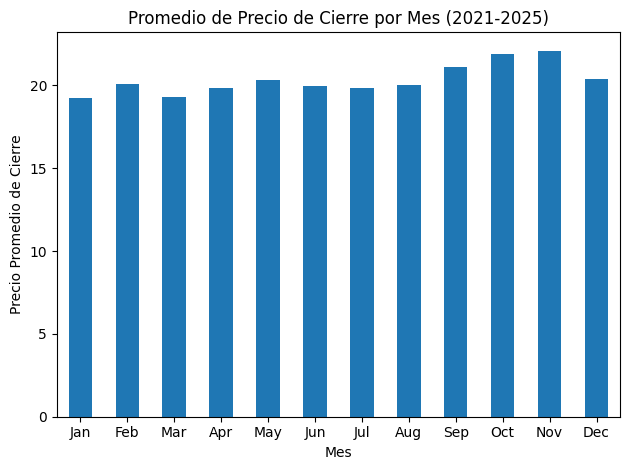

In [ ]:
df.index = pd.to_datetime(df.index)
df_2021 = df.loc['2021-01-01':]


#Promedio de cierre por mes calendario
df_2021['Month'] = df_2021.index.month
monthly_avg = df_2021.groupby('Month')['Close'].mean()

plt.figure()
monthly_avg.plot(kind='bar')
plt.title('Promedio de Precio de Cierre por Mes (2021-2025)')
plt.xlabel('Mes')
plt.ylabel('Precio Promedio de Cierre')
plt.xticks(ticks=range(0,12), labels=[calendar.month_abbr[m] for m in range(1,13)], rotation=0)
plt.tight_layout()
plt.show()


#### **Revision de ciclicidad en el precio del azucar**
Revisamos si existe algun patron o ciclo dentro del precio del azucar

<ipython-input-6-2ee2a49268ef>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  close_m = (df['Close'].resample('M').mean().to_frame(name='Close'))


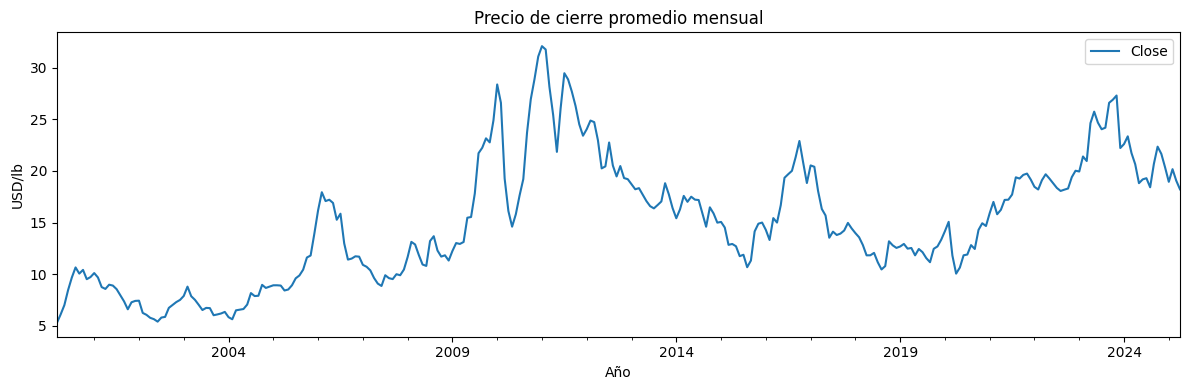

In [ ]:
close_m = (df['Close'].resample('M').mean().to_frame(name='Close'))

fig, ax = plt.subplots(figsize=(12, 4))
close_m.plot(ax=ax)
ax.set_title('Precio de cierre promedio mensual')
ax.set_ylabel('USD/lb')
ax.set_xlabel('Año')
plt.tight_layout()
plt.show()

En este caso, con la grafica del precio de cierre promedio mensual del azucar, podemos observar que contamos con posibles ciclos extendidos de 4 a 6 años, teniendo su maximo en el 2011.

Podemos observar que contamos con volatililiades asimetricas, en donde existen subidas abruptas de los precios y caidas mas prolongadas.

Por ultimo se observa que no contamos con repeticiones mensuales fijas, por lo que la estacionalidad de 12 meses es debil.

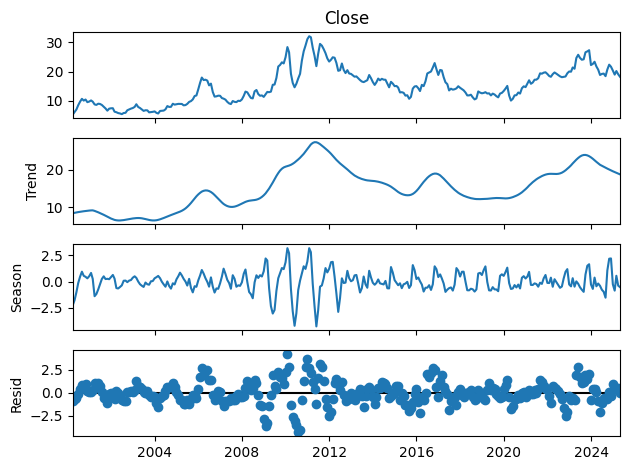

In [ ]:
stl = STL(close_m['Close'], period=12)
res  = stl.fit()
res.plot()
plt.show()

Al aplicar un grafico de STL, podemos terminar de comprobar que existen 3 grandes picos (2006-07, 2010-11, 2023-24) y valles en 2004, 2013-14 y 2018-20.

Asi mismo podemos observar que en el periodo 2008 y 2014 existe fuerte fluctuaciones, posiblemente por factores externos en los mercados. Por lo que podemos observar ciclos mas frecuentes y un patron anual estable y pequeño


##### **2016 - 2025**

<ipython-input-8-2fc1b4ba6697>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  close_m = (df_16_25['Close'].resample('M').mean().to_frame(name='Close'))


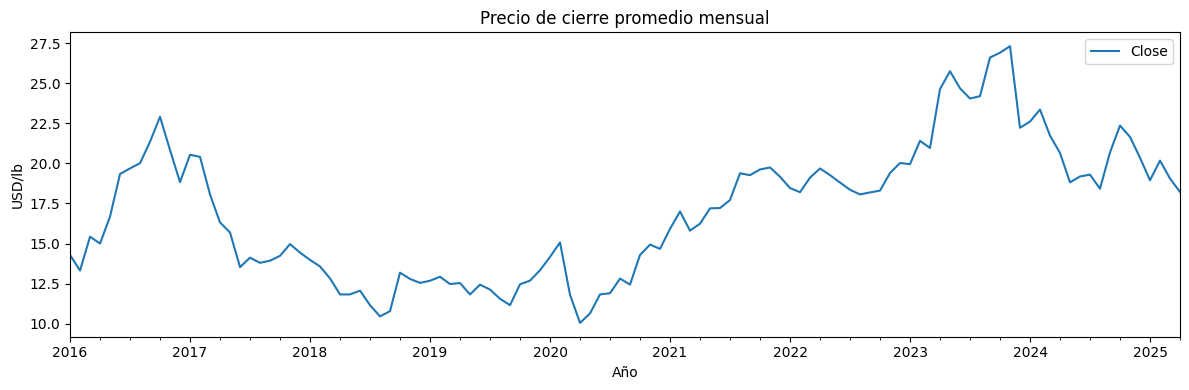

In [ ]:
df_16_25 = df.loc['2016':'2025']

close_m = (df_16_25['Close'].resample('M').mean().to_frame(name='Close'))

fig, ax = plt.subplots(figsize=(12, 4))
close_m.plot(ax=ax)
ax.set_title('Precio de cierre promedio mensual')
ax.set_ylabel('USD/lb')
ax.set_xlabel('Año')
plt.tight_layout()
plt.show()

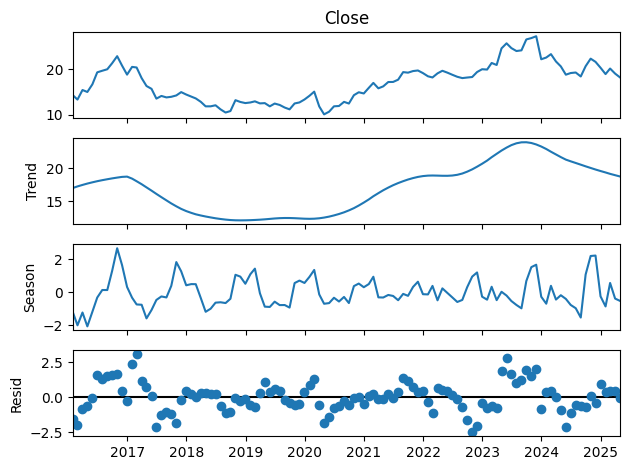

In [ ]:
stl = STL(close_m['Close'], period=12)
res  = stl.fit()
res.plot()
plt.show()

##### **2021 - 2025**

<ipython-input-10-12af843aece0>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  close_m = (df_21_25['Close'].resample('M').mean().to_frame(name='Close'))


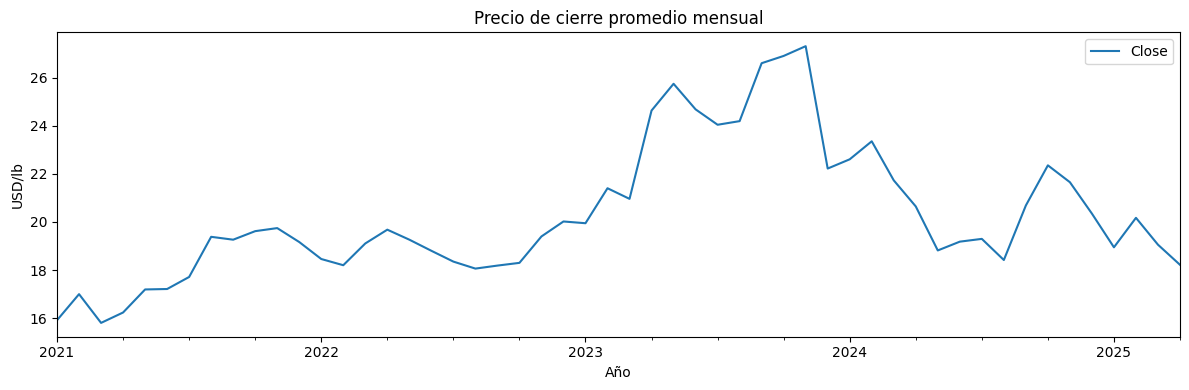

In [ ]:
df_21_25 = df.loc['2021':'2025']

close_m = (df_21_25['Close'].resample('M').mean().to_frame(name='Close'))

fig, ax = plt.subplots(figsize=(12, 4))
close_m.plot(ax=ax)
ax.set_title('Precio de cierre promedio mensual')
ax.set_ylabel('USD/lb')
ax.set_xlabel('Año')
plt.tight_layout()
plt.show()

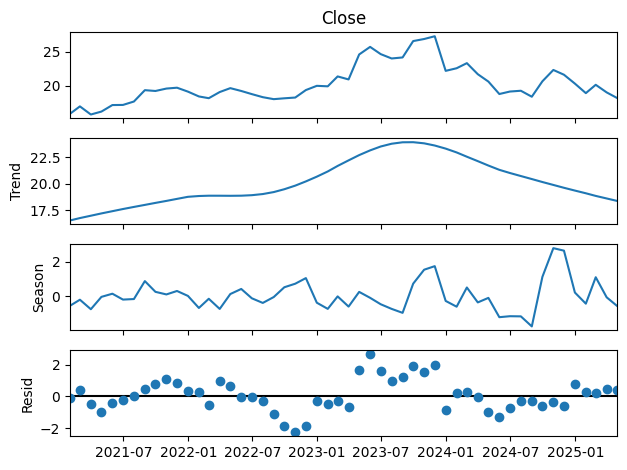

In [ ]:
stl = STL(close_m['Close'], period=12)
res  = stl.fit()
res.plot()
plt.show()

#### **Determinacion de fechas optimas para entrenamiento del modelo**

**Metodo PELT**

El método PELT (Pruned Exact Linear Time) es un algoritmo de detección de “puntos de cambio” en series temporales que identifica automáticamente los instantes en que la serie sufre variaciones significativas en su comportamiento estadístico (media, varianza o tendencia).

Realizaremos primero un análisis de rupturas estructurales sobre la serie de log_Close empleando el método PELT, de modo que podamos segmentar nuestro histórico en tramos homogéneos y así determinar fechas clave donde cambian las dinámicas de precio. A partir de esos puntos de quiebre definiremos varias ventanas de entrenamiento que arrancarán justo después de cada ruptura significativa.

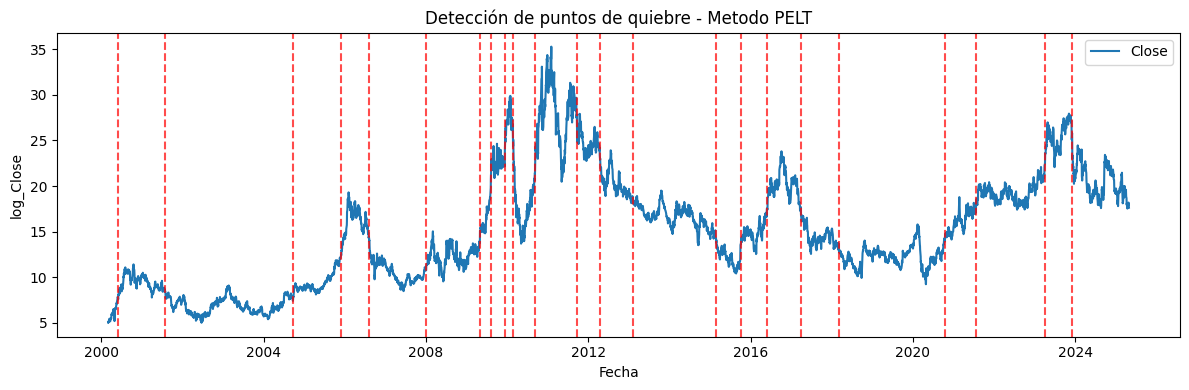

In [ ]:
#Apolicacion del metodo Pelt
signal = df['Close'].values
algo = rpt.Pelt(model="rbf").fit(signal)
breaks = algo.predict(pen=20)

dates = df.index.to_pydatetime()
break_dates = [dates[b-1] for b in breaks[:-1]]

#Grafico de los puntos de quiebre detectados
plt.figure(figsize=(12, 4))
plt.plot(dates, signal, label='Close')
for bd in break_dates:
    plt.axvline(bd, color='red', linestyle='--', alpha=0.7)
plt.title('Detección de puntos de quiebre - Metodo PELT')
plt.xlabel('Fecha')
plt.ylabel('log_Close')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
break_dates

[datetime.datetime(2000, 6, 1, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>),
 datetime.datetime(2001, 7, 27, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>),
 datetime.datetime(2004, 9, 23, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>),
 datetime.datetime(2005, 11, 28, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
 datetime.datetime(2006, 8, 9, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>),
 datetime.datetime(2008, 1, 4, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
 datetime.datetime(2009, 4, 28, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>),
 datetime.datetime(2009, 8, 6, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>),
 datetime.datetime(2009, 12, 14, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>),
 datetime.datetime(2010, 2, 26, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day

In [ ]:
hoy = df.index[-1]

#Ventanas candidatas
candidatas = {
    #Breakpoints relevantes
    "desde_2013": break_dates[13],
    "desde_2016": break_dates[16],
    "desde_2018": break_dates[18],
    "desde_2020": break_dates[19],
    "desde_2021": break_dates[20],
    "desde_2023_abr": break_dates[21],

    #Ventanas de longitud fija
    "3y_reciente":  hoy - timedelta(days=3*365),
    "5y_reciente":  hoy - timedelta(days=5*365),
    "7y_reciente":  hoy - timedelta(days=7*365),
    "10y_reciente": hoy - timedelta(days=10*365),
}

A continuación, evaluaremos cada ventana usando validación cruzada temporal (TimeSeriesSplit) y calculando el MAE de los pronósticos. Aunque este enfoque se suele asociar con la comparación de configuraciones de SARIMAX, la misma métrica y esquema de splits nos ofrece una guía cuantitativa fiable para cualquier modelo de series temporales (LSTM, GBM, Prophet, etc.).

De esta forma, elegimos la ventana que minimice el error medio absoluto, garantizando que nuestro modelo aprenda patrones vigentes y no arrastre ruido de periodos anteriores.

**Modelo de 30 dias**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

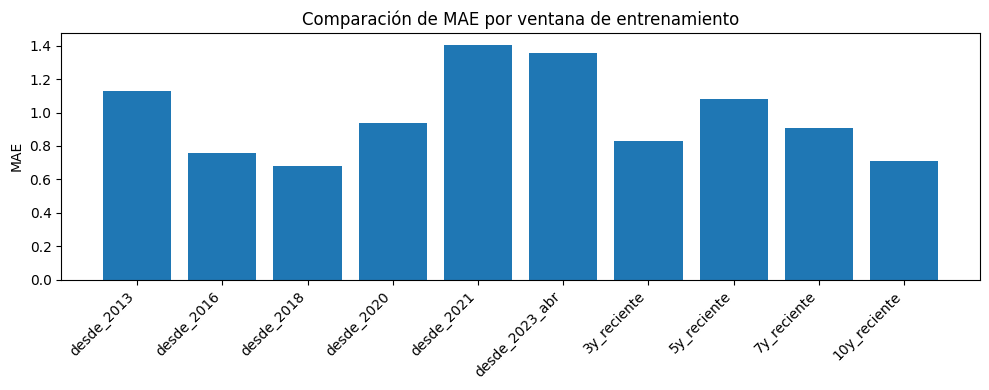

In [ ]:
def fit_sarimax(train_series):
    model = sm.tsa.SARIMAX(train_series, order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
    return model.fit(disp=False)

def cv_mae(series, start_date, horizon=30, n_splits=5):
    sub = series[start_date:]
    tscv = TimeSeriesSplit(n_splits=n_splits)
    maes = []
    for train_idx, test_idx in tscv.split(sub):
        train = sub.iloc[train_idx]
        test  = sub.iloc[test_idx]
        test = test.iloc[:horizon]
        if len(test) < horizon:
            break
        fit = fit_sarimax(train)
        pred = fit.forecast(steps=horizon)
        maes.append(mean_absolute_error(test, pred))
    return np.mean(maes)

resultados = {}
for name, start in candidatas.items():
    mae = cv_mae(df['Close'], start_date=start, horizon=30, n_splits=5)
    resultados[name] = mae

#Graficamos los resultados
names  = list(resultados.keys())
values = list(resultados.values())

plt.figure(figsize=(10,4))
plt.bar(names, values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('MAE')
plt.title('Comparación de MAE por ventana de entrenamiento')
plt.tight_layout()
plt.show()

Basándonos en la comparación de MAE para cada ventana, podemos observar que el periodo de los últimos 3 años (3y_reciente) es el que arroja el error medio absoluto más bajo, seguido por la fecha desde el 2018 y la fecha desde el 2016.

**Modelo de 6 meses**

<ipython-input-16-4ae8d3ba3dfe>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  series_m = df['Close'].resample('M').last()
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


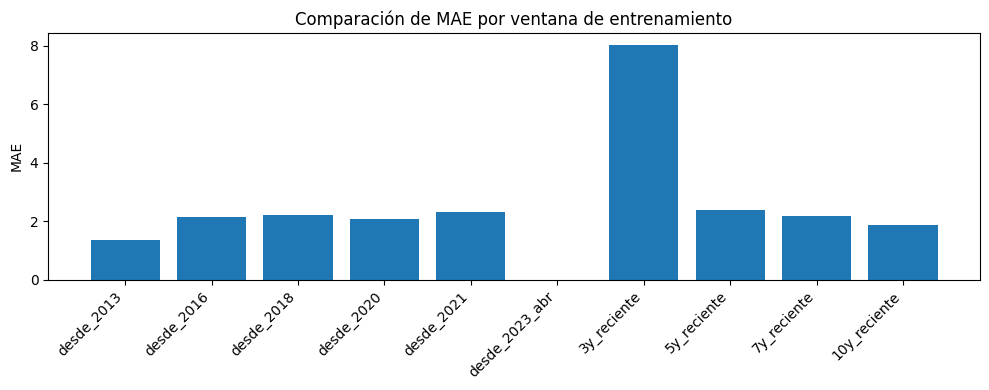

In [ ]:
series_m = df['Close'].resample('M').last()

def fit_sarimax_m(train_series):
    model = sm.tsa.SARIMAX(
        train_series,
        order=(1, 1, 1),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    return model.fit(disp=False)

def cv_mae_m(series, start_date, horizon=6, n_splits=5):
    sub = series[start_date:]
    tscv = TimeSeriesSplit(n_splits=n_splits)
    maes = []
    for train_idx, test_idx in tscv.split(sub):
        train = sub.iloc[train_idx]
        test  = sub.iloc[test_idx][:horizon]
        if len(test) < horizon:
            break
        fit  = fit_sarimax_m(train)
        pred = fit.forecast(steps=horizon)
        maes.append(mean_absolute_error(test, pred))
    return np.mean(maes)


resultados_m = {}
for name, start in candidatas.items():
    resultados_m[name] = cv_mae_m(series_m, start, horizon=6, n_splits=5)

#Graficamos los resultados
plt.figure(figsize=(10,4))
plt.bar(resultados_m.keys(), resultados_m.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel('MAE')
plt.title('Comparación de MAE por ventana de entrenamiento')
plt.tight_layout()
plt.show()

Para el pronostico de 6 meses, la comparación de MAE muestra que la ventana que arranca en 2013, desde_2013, es la que obtiene el error más bajo. Esto confirma que, para horizontes semestrales, necesitamos una historia bastante más amplia que incluya al menos un ciclo completo de mercado.

# **Ingenieria de atributos**

### **Variables endogenas modelo diario**

Las variables endógenas seleccionadas son las siguientes:

* log_Close
* ret_1d
* ma_7 y ma_14
* std_7
* true_range
* boll_b
* log_Volume
* dow (día-semana)
* close_open_diff

La variable log_Close representa el precio de cierre transformado a escala logarítmica, lo que estabiliza la varianza y mejora considerablemente la precisión al evitar que movimientos bruscos.

El retorno diario (ret_1d) mide la fuerza inmediata y el momentum del mercado, indicando si el precio tiene más probabilidad de continuar o revertirse en la próxima sesión.

Las medias móviles (ma_7 y ma_14) captan claramente la tendencia reciente del precio, suavizando el ruido diario y facilitando identificar movimientos sostenidos.

La volatilidad reciente (std_7) junto con la amplitud real diaria (true_range) reflejan la intensidad y el estrés del mercado, permitiendo anticipar movimientos grandes o inusuales en los precios diarios.

La posición dentro de las Bandas de Bollinger (boll_b) es clave para detectar condiciones de sobre-compra o sobre-venta, sugiriendo posibles retrocesos rápidos.

La variable log_Volume ayuda a validar movimientos genuinos en precio al relacionarlos directamente con el volumen negociado; un alto volumen confirma tendencias más fuertes.

También se toma en cuenta el día de la semana (dow) debido a patrones específicos en el mercado de futuros del azúcar relacionados con contratos y liquidaciones semanales.

Finalmente, la diferencia entre cierre y apertura (close_open_diff) mide claramente la dirección intradía del mercado, indicando fuerza alcista o bajista durante cada sesión.

**Agregamos las variables exogenas seleccionadas a nuestro dataframe:**

In [ ]:
#Log_Close: precio de cierre en escala logarítmica
df['log_Close'] = np.log(df['Close'])

#ret_1d: retorno porcentual diario
df['ret_1d'] = df['Close'].pct_change()

#ma_7, ma_14: medias móviles de 7 y 14 días
df['ma_7']  = df['Close'].rolling(window=7,  min_periods=1).mean()
df['ma_14'] = df['Close'].rolling(window=14, min_periods=1).mean()

#std_7: volatilidad histórica (std. móvil 7 días)
df['std_7'] = df['Close'].rolling(window=7, min_periods=1).std()

#true_range: rango verdadero diario
prev_close = df['Close'].shift(1)
tr1 = df['High'] - df['Low']
tr2 = (df['High'] - prev_close).abs()
tr3 = (df['Low']  - prev_close).abs()
df['true_range'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

#boll_b: %B de Bandas de Bollinger (20d)
ma20  = df['Close'].rolling(window=20, min_periods=1).mean()
std20 = df['Close'].rolling(window=20, min_periods=1).std()
lower = ma20 - 2*std20
upper = ma20 + 2*std20
df['boll_b'] = (df['Close'] - lower) / (upper - lower)

#og_Volume: volumen en escala logarítmica
df['log_Volume'] = np.log(df['Volume'] + 1)

#dow: día de la semana (0=lunes … 6=domingo)
df['dow'] = df.index.dayofweek

#close_open_diff: diferencia cierre - apertura
df['close_open_diff'] = df['Close'] - df['Open']


### **Variables endogenas modelo mensual**

Las variables endógenas seleccionadas son las siguientes:

* ret_1m
* ret_3m
* ma_3m
* mom_3m
* std_3m
* range_m
* boll_b_m
* log_Volume_m
* moy (month-of-year)
* quarter
* ret_12m
* close_lag1

ret_1m: cambio porcentual (o en log) del cierre de este mes respecto al cierre del mes anterior, capturando el impulso inmediato a escala mensual.

ret_3m: variación del cierre frente a hace tres meses, útil para distinguir correcciones cortas de giros de tendencia más profundos.

ma_3m: media móvil simple de los cierres de los últimos 3 meses, suaviza ruido mensual y define soportes/resistencias dinámicas.

mom_3m: diferencia entre el cierre del mes actual y la ma_3m, indica sobre-compra o sobre-venta en un contexto trimestral.

std_3m: desviación estándar de los retornos mensuales en los últimos 3 meses, mide el estrés y la volatilidad a nivel trimestral.

range_m: (High – Low) / Close del mes, refleja la amplitud real del mes, análogo al true range diario a escala mensual.

boll_b_m: posición relativa del cierre dentro de las Bandas de Bollinger mensuales (usando ma_3m y std_3m), detecta extremos de precio.

log_Volume_m: logaritmo del volumen total o promedio negociado en el mes, confirma la fuerza de los movimientos de precio.

moy (month-of-year): número del mes (1–12), captura estacionalidades anuales ligadas a zafras y embarques.

quarter: trimestre del año (1–4), recoge efectos de balances, ajustes fiscales y rotaciones de cartera.

ret_12m: variación del cierre respecto al mismo mes del año anterior, proxy de ciclo agrícola y demanda global a largo plazo.

close_lag1: cierre del mes anterior como variable de lag explícito, a menudo tan predictiva como una media móvil.

**Agregamos las variables exogenas seleccionadas a nuestro dataframe:**

In [ ]:
df = df.copy()
df['ret_1d'] = df['Close'].pct_change()

df_m = pd.DataFrame()
df_m['Close'] = df['Close'].resample('M').last()

#Momentum
df_m['ret_1m'] = df_m['Close'].pct_change(1)
df_m['ret_3m'] = df_m['Close'].pct_change(3)

#Tendencia corta
df_m['ma_3m'] = df_m['Close'].rolling(3, min_periods=1).mean()

#Volatilidad trimestral
df_m['std_m']  = df['ret_1d'].resample('M').std()
df_m['std_3m'] = df_m['std_m'].rolling(3, min_periods=1).mean()

#Volumen mensual
df_m['log_Volume_m'] = np.log(df['Volume'].resample('M').sum() + 1)

#Cierre lag 1 mes
df_m['close_lag1'] = df_m['Close'].shift(1)

#Mes del año
df_m['moy'] = df_m.index.month


<ipython-input-7-603e1e4a6914>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_m['Close'] = df['Close'].resample('M').last()
<ipython-input-7-603e1e4a6914>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_m['std_m']  = df['ret_1d'].resample('M').std()
<ipython-input-7-603e1e4a6914>:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_m['log_Volume_m'] = np.log(df['Volume'].resample('M').sum() + 1)


### **Variables exogenas**

Las variables exogenas seleccionadas son las siguientes:

* Tipo de cambio USD/BRL

* Precio del petróleo WTI

* índice VIX de


El tipo de cambio USD/BRL afecta significativamente el precio porque Brasil es el mayor productor y exportador mundial de azúcar; una devaluación del real brasileño reduce costos locales, incentivando exportaciones y bajando precios globales, mientras que una apreciación genera presión alcista en los precios internacionales.

El precio del petróleo WTI influye debido a la relación azúcar-etanol, pues incrementos en los precios petroleros aumentan la demanda de etanol (biocombustible producido con caña), reduciendo así la oferta de azúcar y elevando su precio internacional.

Finalmente, el índice VIX es un indicador del nivel de incertidumbre en los mercados financieros globales; valores elevados reflejan mayor volatilidad y aversión al riesgo, lo cual históricamente ha impactado negativamente en los precios de commodities como el azúcar.

**Agregamos las variables exogenas seleccionadas a nuestro dataframe para el modelo diario:**

In [ ]:
#WTI (CL=F)
ticker_wti = yf.Ticker("CL=F")
wti = ticker_wti.history(start="2000-03-01", end="2025-04-30", interval="1d")["Close"].rename("WTI")

#Unificar dataframes
ext = wti.reindex(df.index).ffill()
df = df.join(ext)

In [ ]:
#USDBRL (BRL=X)
ticker_wti = yf.Ticker("BRL=X")
fx = ticker_wti.history(start="2000-03-01", end="2025-04-30", interval="1d")["Close"].rename("USDBRL")

fx_mod = fx.copy()
fx_mod.index = fx_mod.index.tz_localize(None)
fx_mod.index = fx_mod.index.normalize()
fx_mod.index = fx_mod.index.tz_localize(df.index.tz)
fx_aligned = fx_mod.reindex(df.index).ffill()


df["USDBRL"] = fx_aligned

In [ ]:
#"^VIX"
ticker_wti = yf.Ticker("^VIX")
vix = ticker_wti.history(start="2000-03-01", end="2025-04-30", interval="1d")["Close"].rename("VIX")

vix_mod = vix.copy()
vix_mod.index = vix_mod.index.tz_localize(None)
vix_mod.index = vix_mod.index.normalize()
vix_mod.index = vix_mod.index.tz_localize(df.index.tz)
vix_aligned = vix_mod.reindex(df.index).ffill()


df["VIX"] = vix_aligned

In [ ]:
df_m['VIX_m_mean']    = df['VIX'].resample('M').mean()
df_m['WTI_m_mean']    = df['WTI'].resample('M').mean()
df_m['USDBRL_m_mean'] = df['USDBRL'].resample('M').mean()

<ipython-input-11-82e6e91ebac6>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_m['VIX_m_mean']    = df['VIX'].resample('M').mean()
<ipython-input-11-82e6e91ebac6>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_m['WTI_m_mean']    = df['WTI'].resample('M').mean()
<ipython-input-11-82e6e91ebac6>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_m['USDBRL_m_mean'] = df['USDBRL'].resample('M').mean()


In [ ]:
to_lag = [
    'ret_1m', 'ret_3m',
    'ma_3m', 'std_3m',
    'log_Volume_m', 'moy',
    'VIX_m_mean', 'WTI_m_mean', 'USDBRL_m_mean'
]
for col in to_lag:
    df_m[f'{col}_lag1'] = df_m[col].shift(1)

### **Matriz de correlacion**

Realizaremos un analisis de correlación entre las variables endógenas (precio, retornos, volatilidad, volumen, etc.) y exógenas (WTI, USD/BRL, VIX) con el fin de cuantificar la fuerza y dirección de su relación mutua

                 log_Close    ret_1d      ma_7  true_range  close_open_diff  \
log_Close         1.000000  0.015794  0.971049    0.578508         0.000261   
ret_1d            0.015794  1.000000 -0.026449   -0.032992         0.827790   
ma_7              0.971049 -0.026449  1.000000    0.633999        -0.040938   
true_range        0.578508 -0.032992  0.633999    1.000000        -0.077165   
close_open_diff   0.000261  0.827790 -0.040938   -0.077165         1.000000   
log_Volume        0.286988  0.010950  0.234270    0.160384        -0.003960   
WTI               0.655516  0.003854  0.618424    0.334800        -0.021000   
USDBRL            0.071337  0.002335  0.025226   -0.149122         0.009832   
VIX              -0.133631 -0.009350 -0.109747    0.059924        -0.009185   

                 log_Volume       WTI    USDBRL       VIX  
log_Close          0.286988  0.655516  0.071337 -0.133631  
ret_1d             0.010950  0.003854  0.002335 -0.009350  
ma_7               0.234270  

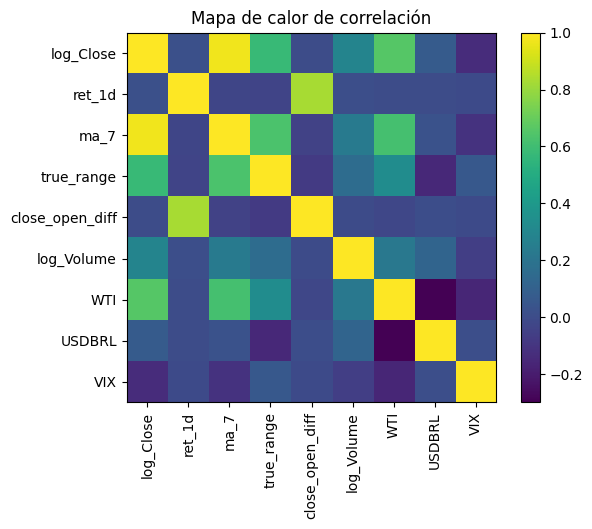

In [ ]:
#Calcular la matriz de correlación
columnas_numericas = ['log_Close', 'ret_1d', 'ma_7', 'true_range', 'close_open_diff', 'log_Volume', 'WTI', 'USDBRL', 'VIX']
matriz_correlacion = df[columnas_numericas].corr()
print(matriz_correlacion)

#Visualizar el mapa de calor de correlación
plt.imshow(matriz_correlacion, cmap='viridis', interpolation='none')
plt.colorbar()
plt.title("Mapa de calor de correlación")

#Para que aparezcan los nombres de las columnas en los ejes
columnas = matriz_correlacion.columns
plt.xticks(range(len(columnas)), columnas, rotation=90)
plt.yticks(range(len(columnas)), columnas)

plt.show()

Podemos ver que como lo mencionamos anteriormente algunas variables comparten  la misma información. log_Close y ma_7 presentan una correlación de ~0.97, lo que indica que ambas capturan prácticamente la misma tendencia de precios a corto plazo. De igual modo, ret_1d y close_open_diff tienen ρ ≈ 0.83, pues miden de forma muy similar el movimiento diario (en porcentaje y en valor absoluto, respectivamente).

Podemos observar que otras variables como log_Volume, USDBRL y VIX muestran correlaciones bajas con el resto. Tambien, el precio del petroleo (WTI) y true_range mantienen correlaciones moderadas con la tendencia del azúcar.

# **Modelo diario 30 dias**

### **Preparacion de los datos**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6310 entries, 2000-03-01 00:00:00-05:00 to 2025-04-29 00:00:00-04:00
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             6310 non-null   float64
 1   High             6310 non-null   float64
 2   Low              6310 non-null   float64
 3   Close            6310 non-null   float64
 4   Volume           6310 non-null   int64  
 5   Dividends        6310 non-null   float64
 6   Stock Splits     6310 non-null   float64
 7   log_Close        6310 non-null   float64
 8   ret_1d           6309 non-null   float64
 9   ma_7             6310 non-null   float64
 10  ma_14            6310 non-null   float64
 11  std_7            6309 non-null   float64
 12  true_range       6310 non-null   float64
 13  boll_b           6309 non-null   float64
 14  log_Volume       6310 non-null   float64
 15  dow              6310 non-null   int32  
 16  close_open_d

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,log_Close,ret_1d,ma_7,ma_14,std_7,true_range,boll_b,log_Volume,dow,close_open_diff,WTI,USDBRL,VIX
Date,,,,,,,,,,,,,,,,,,,,
2000-03-01 00:00:00-05:00,4.98,5.14,4.98,5.08,10467,0.0,0.0,1.625311,NaN,5.0800,5.0800,NaN,0.16,NaN,9.256078,2,0.10,NaN,NaN,21.639999
2000-03-02 00:00:00-05:00,5.08,5.13,4.94,4.96,9638,0.0,0.0,1.601406,-0.023622,5.0200,5.0200,0.084853,0.19,0.323223,9.173573,3,-0.12,NaN,NaN,21.059999
2000-03-03 00:00:00-05:00,4.96,5.06,4.96,5.05,5879,0.0,0.0,1.619388,0.018145,5.0300,5.0300,0.062450,0.10,0.580065,8.679312,4,0.09,NaN,NaN,19.209999
2000-03-06 00:00:00-05:00,5.10,5.16,5.03,5.04,11290,0.0,0.0,1.617406,-0.001980,5.0325,5.0325,0.051235,0.13,0.536596,9.331761,0,-0.06,NaN,NaN,21.500000
2000-03-07 00:00:00-05:00,5.05,5.14,5.03,5.07,9369,0.0,0.0,1.623341,0.005952,5.0400,5.0400,0.047434,0.11,0.658114,9.145268,1,0.02,NaN,NaN,24.309999


In [ ]:
#Eliminar timezone
df.index = pd.to_datetime(df.index).tz_localize(None)
df.index.name = 'Date'

#Lista de variables extras
variables = [
    'ret_1d', 'ma_7', 'ma_14', 'std_7', 'true_range',
    'boll_b', 'log_Volume', 'dow', 'close_open_diff',
    'WTI', 'USDBRL', 'VIX'
]

#Datos de entrenamiento y de test
train = df.loc['2018-01-01':'2024-12-31'].asfreq('D')
test_index = pd.date_range('2025-01-01', '2025-01-31', freq='D')

#Dataframe de variables
df_variables = df[variables].asfreq('D').ffill().bfill()

actual_2025 = df['Close'].reindex(test_index)

## **Modelo ARIMAX**

Como primer modelo emplearemos un modelo ARIMAX (Autoregressive Integrated Moving Average with eXogenous variables) para pronosticar el precio diario del azúcar.

ARIMAX extiende la logica del clasico ARIMA: captura la dependencia temporal propia de la serie (componentes autorregresivas p, de integración d y de medias móviles q) y, además, incorpora regresores externos que explican variaciones adicionales; en nuestro caso, indicadores técnicos del mercado y variables macro como el WTI, el tipo de cambio USD/BRL y el índice VIX.

In [ ]:
#Entrenamiento

best_aic = np.inf
best_order = None
best_model = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                mod = SARIMAX(
                    train['Close'],
                    exog=df_variables.loc[train.index, variables],
                    order=(p, d, q),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                res = mod.fit(disp=False)
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = (p, d, q)
                    best_model = res
            except:
                pass

if best_model is None:
    best_order = (1, 0, 1)
    best_model = SARIMAX(
        train['Close'],
        order=best_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

#Pronostico diario
arima_fc = best_model.get_forecast(
    steps=len(test_index),
    exog=(df_variables.loc[test_index, variables]
          if best_order != (1, 0, 1) else None)
).predicted_mean
arima_fc.index = test_index

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

<ipython-input-78-f2f6042c50f3>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax.plot(test_index, arima_mean, 'b--', color='purple', label='ARIMAX mean')


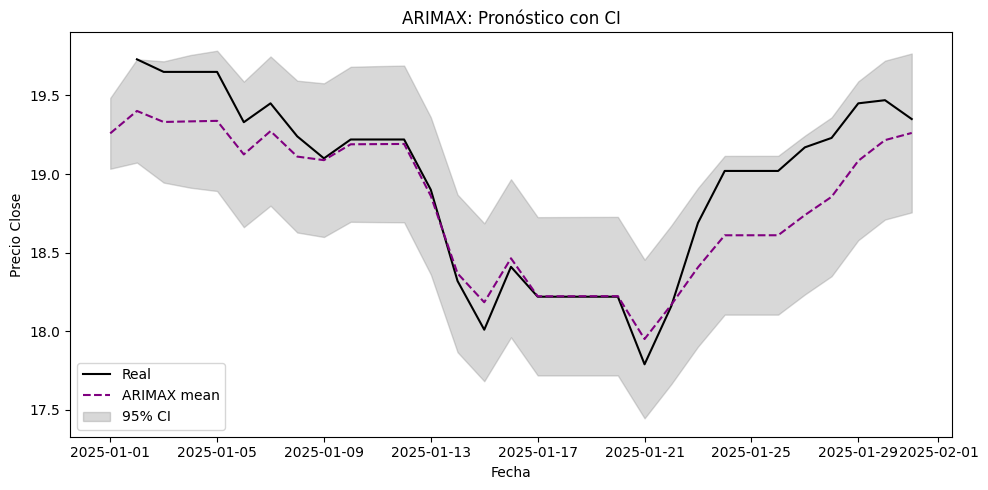

In [ ]:
fc_obj = best_model.get_forecast(
    steps=len(test_index),
    exog=(df_variables.loc[test_index, variables]
          if best_order != (1, 0, 1) else None)
)


arima_mean = fc_obj.predicted_mean
arima_mean.index = test_index

#Obtener los intervalos de confianza al 95%
ci = fc_obj.conf_int(alpha=0.05)
ci.index = test_index

#Grafica de enero con banda de confianza
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test_index, actual_2025.ffill(), 'k-', label='Real')
ax.plot(test_index, arima_mean, 'b--', color='purple', label='ARIMAX mean')

ax.fill_between(
    test_index,
    ci['lower Close'],
    ci['upper Close'],
    color='gray', alpha=0.3,
    label='95% CI'
)

ax.set_title("ARIMAX: Pronóstico con CI")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio Close")
ax.legend()
plt.tight_layout()
plt.show()


Podemos observar que el precio real del azucar durante enero de 2025 (trazo negro) con el pronostico generado por el modelo ARIMAX (linea azul punteada).

La banda gris representa el intervalo de confianza al 95 %; muestra la region donde, segun el modelo, deberia caer el valor verdadero la mayor parte del tiempo.

Se observa que el pronostico sigue de cerca la trayectoria real: acompana el descenso abrupto hacia mediados de mes y la recuperacion posterior, manteniendose casi siempre dentro de la franja de incertidumbre. Esto sugiere que el modelo captura bien la dinamica diaria y proporciona estimaciones con un margen de error razonable.

**back-testing del modelo**

El back-testing testing es una forma de validar el modelo, en mi caso solo usaremos el periodo del 2024, debido a temas de tiempo.

In [ ]:
def backtest_arimax_fixed_order(df, df_vars, variables,
                                best_order,
                                initial_train_end='2022-12-31',
                                horizon=30,
                                step=30):

    all_fc, all_true = [], []
    train_end = pd.to_datetime(initial_train_end)
    last_date = df.index.max() - pd.Timedelta(days=horizon)

    while train_end <= last_date:
        #Ventana de entrenamiento y test
        train_idx = df.loc[:train_end].index
        test_idx  = pd.date_range(train_end + pd.Timedelta(days=1),
                                  periods=horizon, freq='D')

        #Entrenamiento
        mod = SARIMAX(
            df['Close'].loc[train_idx],
            exog=df_vars.loc[train_idx, variables],
            order=best_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = mod.fit(disp=False)

        #Forecast
        exog_fut = df_vars.reindex(test_idx).ffill().bfill()[variables]
        fc = res.get_forecast(steps=horizon, exog=exog_fut).predicted_mean
        fc.index = test_idx

        #Reales
        true = df['Close'].reindex(test_idx)

        all_fc.append(fc)
        all_true.append(true)

        train_end += pd.Timedelta(days=step)

    preds = pd.concat(all_fc)
    reals = pd.concat(all_true)
    return reals, preds

#Aplicamos la funcion
best_order = (2,1,1)
reals, preds = backtest_arimax_fixed_order(
    df, df_variables, variables,
    best_order=best_order,
    initial_train_end='2023-12-31',
    horizon=30,
    step=30
)

mask = reals.notna() & preds.notna()
rmse = np.sqrt(mean_squared_error(reals[mask], preds[mask]))
mae  = mean_absolute_error  (reals[mask], preds[mask])
print(f"Backtest ARIMAX fijo: RMSE={rmse:.4f}, MAE={mae:.4f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/stat

Backtest ARIMAX fijo: RMSE=0.3268, MAE=0.2308


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


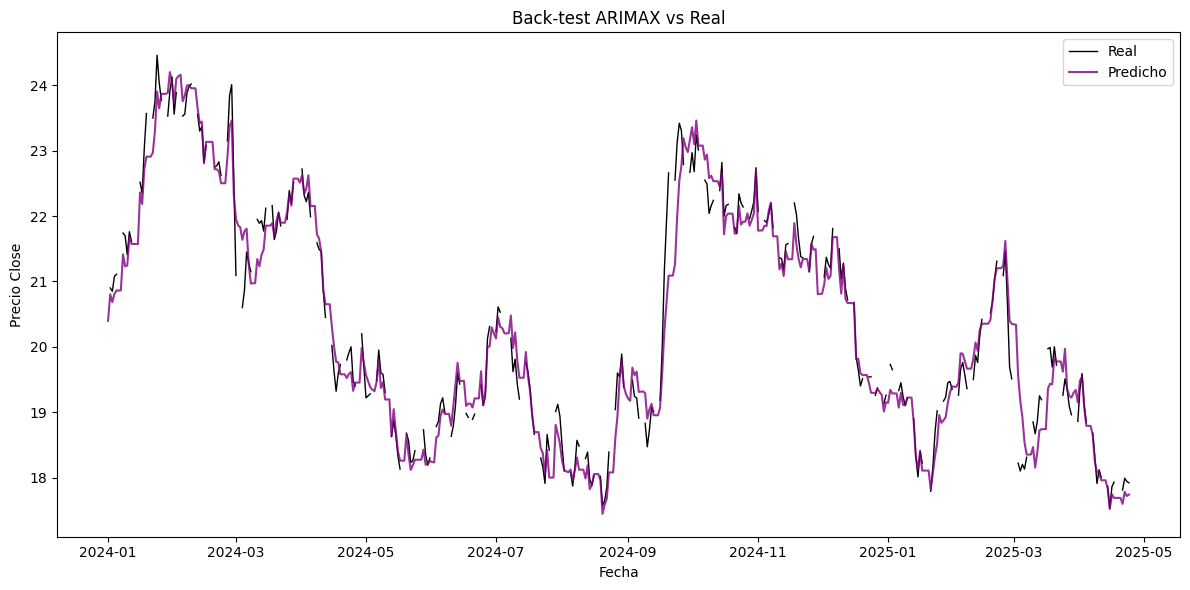

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(reals.index, reals,  label='Real',      color='black', linewidth=1)
plt.plot(preds.index, preds,  label='Predicho', color='purple', alpha=0.8)

plt.title("Back-test ARIMAX vs Real")
plt.xlabel("Fecha")
plt.ylabel("Precio Close")
plt.legend()
plt.tight_layout()
plt.show()

Al realizar el back-testing sobre los 12 meses del 2024 confirmamos que que el modelo ARIMAX seleccionado y las variables exogenas WTI, USD/BRL, VIX y los indicadores técnicos, reproducen la trayectoria diaria del precio del azacar: obtuvo un RMSE promedio de 0.3268 y un MAE de 0.2308, equivalentes a 1.15 % sobre un precio medio.

En la grafica del back test la linea pronosticada se coloca casi por completo con la serie real en la mayor parte del año, y los desajustes se concentran en picos de volatilidad inusual; sin embargo, el modelo mantiene la forma general de las fases alcistas de febrero y septiembre, así como las caídas entre mayo y julio.

Los resultados evidencian un desempeño estable y un nivel de error lo suficientemente bajo para considerar el ARIMAX como una herramienta confiable de pronóstico diario.

## **Modelo Prophet**

Prophet es un modelo de series temporales basado en una descomposición aditiva de la serie, donde la tendencia se ajusta como una función lineal o logística con puntos de cambio automáticos, y las estacionalidades (diaria, semanal y anual) se modelan mediante funciones periódicas.

Gracias a su formulación bayesiana y a parámetros intuitivos (como la escala de cambios de punto y la fuerza de estacionalidad), Prophet resulta robusto frente a datos perdidos o atípicos y facilita la generación de pronósticos con intervalos de confianza, lo que lo hace especialmente práctico para aplicaciones de negocio donde se requiere interpretar rápidamente el impacto de tendencias y ciclos en la serie histórica.

In [ ]:
#Implementacion del modelo
prophet_df = train.reset_index().rename(columns={'Date':'ds','Close':'y'})
prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)
for var in variables:
    prophet_df[var] = df_variables.loc[prophet_df['ds'], var].values

m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)
for var in variables:
    m.add_regressor(var)
m.fit(prophet_df)

#Creacion del df futuro y predicciones
future = pd.DataFrame({'ds': test_index})
future['ds'] = pd.to_datetime(future['ds'])
for var in variables:
    future[var] = df_variables.loc[future['ds'], var].values

prophet_fc = m.predict(future).set_index('ds')['yhat']
prophet_fc.index = test_index

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jjxew7c/06ad0zu8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jjxew7c/eeb_jvpx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21002', 'data', 'file=/tmp/tmp_jjxew7c/06ad0zu8.json', 'init=/tmp/tmp_jjxew7c/eeb_jvpx.json', 'output', 'file=/tmp/tmp_jjxew7c/prophet_modelhf_8r2b0/prophet_model-20250520153434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:34:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


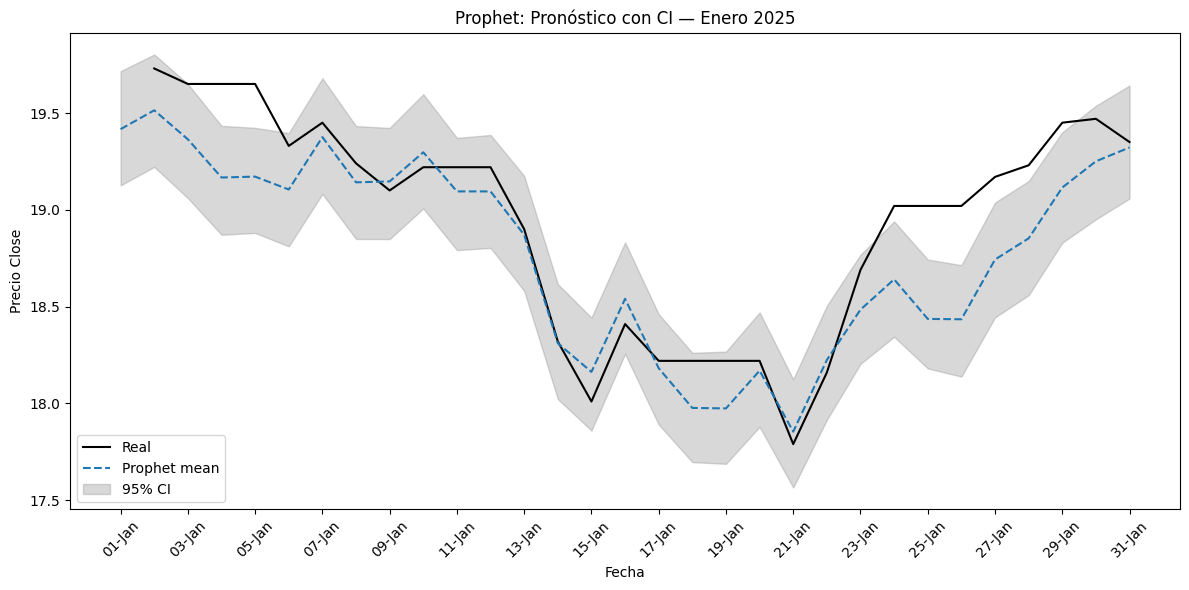

In [ ]:
#Creacion de intervalos de confianza
forecast = m.predict(future).set_index('ds')

prophet_mean  = forecast['yhat']
prophet_lower = forecast['yhat_lower']
prophet_upper = forecast['yhat_upper']

# Aseguramos índices
prophet_mean.index  = test_index
prophet_lower.index = test_index
prophet_upper.index = test_index


#Graficamos
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(test_index, actual_2025.ffill(), color='black', label='Real')
ax.plot(test_index, prophet_mean, linestyle='--', label='Prophet mean')


ax.fill_between(
    test_index,
    prophet_lower,
    prophet_upper,
    color='gray',
    alpha=0.3,
    label='95% CI'
)

#Formato de ejes
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)

ax.set_title("Prophet: Pronóstico con CI — Enero 2025")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio Close")
ax.legend()
plt.tight_layout()
plt.show()

Podemos observar que el precio real del azucar durante enero de 2025 (trazo negro) y el pronostico generado por el modelo Prophet (linea azul punteada).

La banda gris representa el intervalo de confianza al 95 %; muestra la region donde, segun el modelo, deberia caer el valor verdadero la mayor parte del tiempo.

Se aprecia que el pronostico de Prophet acompana fielmente la variacion diaria: respeta la brusca caida a mitad de mes y la posterior recuperacion, manteniendose casi siempre dentro de la franja de incertidumbre.

**back-testing del modelo**

In [ ]:
def backtest_prophet(df, df_vars, variables,
                     initial_train_end='2022-12-31',
                     horizon=30,
                     step=30):

    all_fc, all_true = [], []
    train_end = pd.to_datetime(initial_train_end)
    last_date = df.index.max() - pd.Timedelta(days=horizon)

    while train_end <= last_date:

        train_idx = df.loc[:train_end].index
        test_idx  = pd.date_range(start=train_end + pd.Timedelta(days=1),
                                  periods=horizon, freq='D')

        #Prepara df para Prophet
        train_df = (
            df.loc[train_idx, ['Close']]
              .reset_index()
              .rename(columns={'Date':'ds','Close':'y'})
        )
        train_df['ds'] = pd.to_datetime(train_df['ds']).dt.tz_localize(None)
        # agrega regresores
        for var in variables:
            train_df[var] = df_vars.loc[train_df['ds'], var].values

        #Define y ajusta el modelo
        m = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True
        )
        for var in variables:
            m.add_regressor(var)
        m.fit(train_df)

        #Crea el DataFrame futuro y predice
        future = pd.DataFrame({'ds': test_idx})
        future['ds'] = pd.to_datetime(future['ds'])

        for var in variables:
            future[var] = (
                df_vars
                  .reindex(test_idx)
                  .ffill()
                  .bfill()[var]
                  .values
            )

        fc = m.predict(future).set_index('ds')['yhat']
        fc.index = test_idx

        #  Valores reales
        true = df['Close'].reindex(test_idx)

        all_fc.append(fc)
        all_true.append(true)

        train_end += pd.Timedelta(days=step)

    preds = pd.concat(all_fc)
    reals = pd.concat(all_true)
    return reals, preds

#Aplicación del back-testing
reals_p, preds_p = backtest_prophet(
    df, df_variables, variables,
    initial_train_end='2023-12-31',
    horizon=30,
    step=30
)

mask_p = reals_p.notna() & preds_p.notna()
rmse_p = np.sqrt(mean_squared_error(reals_p[mask_p], preds_p[mask_p]))
mae_p  = mean_absolute_error  (reals_p[mask_p], preds_p[mask_p])
print(f"Backtest Prophet: RMSE={rmse_p:.4f}, MAE={mae_p:.4f}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jjxew7c/s_34ai92.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jjxew7c/p1jbsu9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77413', 'data', 'file=/tmp/tmp_jjxew7c/s_34ai92.json', 'init=/tmp/tmp_jjxew7c/p1jbsu9s.json', 'output', 'file=/tmp/tmp_jjxew7c/prophet_modelv4e0odw1/prophet_model-20250520152718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:27:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:27:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jjxew7c/8p4pbcwv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_jjxew7c/mzxuj371.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Backtest Prophet: RMSE=0.3211, MAE=0.2336


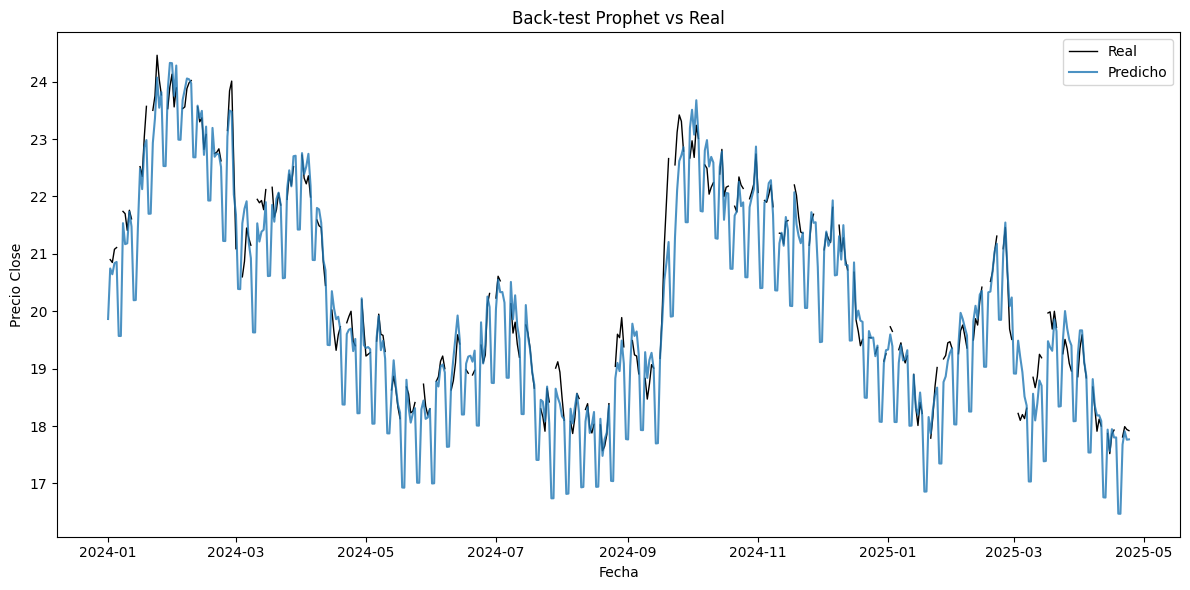

In [ ]:
plt.figure(figsize=(12, 6))

# Serie real vs Prophet
plt.plot(reals_p.index, reals_p,  label='Real',     color='black', linewidth=1)
plt.plot(preds_p.index, preds_p,  label='Predicho', alpha=0.8)


plt.title("Back-test Prophet vs Real")
plt.xlabel("Fecha")
plt.ylabel("Precio Close")
plt.legend()
plt.tight_layout()
plt.show()

Con el back-testing de Prophet en 2024 obtuvimos un RMSE de 0.3211 y un MAE de 0.2336, lo que equivale a un error medio cercano al 1.17% sobre un precio.

En la gráfica de back-testing la curva pronosticada se superpone de manera ajustada a la real, capturando los picos alcistas de febrero y septiembre y las correcciones de mayo–julio.

Sin embargo, se aprecia un efecto “diente de sierra” diario fruto de la estacionalidad diaria activada, que genera más volatilidad fina en la predicción justo en los fines de semana, dias con los cuales no contamos datos en nuestro dataset original.

## **Modelo LightGBM**

LightGBM es un modelo de gradient boosting basado en arboles de decision que entreno en iteraciones sucesivas: cada nuevo arbol corrige los errores residuales del conjunto anterior, de modo que la serie aprendida se va afinando paso a paso.

Gracias a su implementacion con histogramas y a la estrategia leaf-wise, la libreria es muy rapida aun con decenas de miles de observaciones y maneja sin problema variables numericas y categoricas; para este caso le paso tanto indicadores tecnicos (retornos, medias moviles, volatilidad) como factores macro (WTI, USD/BRL, VIX) y el dia de la semana como categoria pura. Se ajusta la complejidad mediante hiperparametros sencillos (num_leaves, learning_rate) y el uso de early-stopping con una ventana de validacion para frenar el sobre-ajuste justo cuando el error deja de mejorar.

In [ ]:
#LightGBM diario
mask        = train['Close'].notna()
X_full      = train.loc[mask, variables].copy()
y_full      = train.loc[mask, 'Close']

#Dow como categoria
X_full['dow'] = X_full['dow'].astype('category')

#Ventana de validacion
val_cut = '2024-10-01'
is_val  = X_full.index >= val_cut

lgb_train = lgb.Dataset(
    X_full.loc[~is_val], y_full.loc[~is_val],
    categorical_feature=['dow']
)
lgb_val   = lgb.Dataset(
    X_full.loc[ is_val], y_full.loc[ is_val],
    categorical_feature=['dow'],
    reference=lgb_train
)

#Entrenamos el modelo
params = {
    'objective'     : 'regression',
    'metric'        : 'rmse',
    'learning_rate' : 0.05,
    'num_leaves'    : 31,
    'verbosity'     : -1,
    'seed'          : 42
}

model_lgb = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_val],
    valid_names=['val'],
    callbacks=[lgb.early_stopping(50),
               lgb.log_evaluation(period=0)]
)

#Prediccion
X_test = df_variables.loc[test_index, variables].copy()
X_test['dow'] = X_test['dow'].astype('category')

lgb_fc = pd.Series(
    model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration),
    index=test_index
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[141]	val's rmse: 0.338277


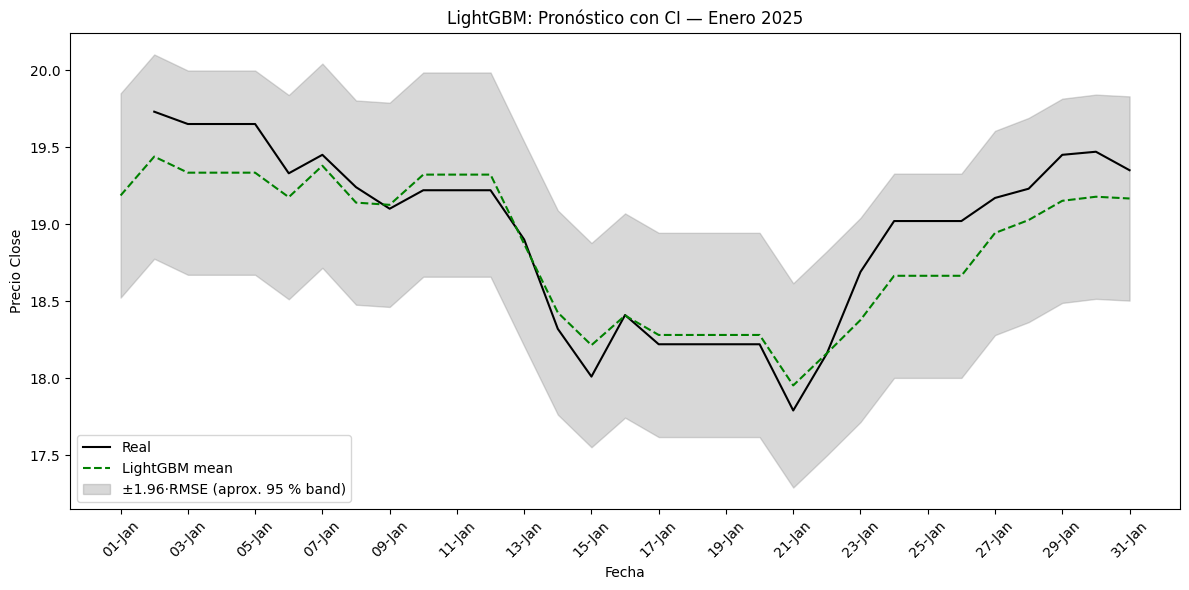

In [ ]:
#Creamos un intervalo de confianza a partir del rmse anterior
rmse_val   = model_lgb.best_score['val']['rmse']
delta      = 1.96 * rmse_val

lgb_mean   = lgb_fc
lgb_lower  = lgb_mean - delta
lgb_upper  = lgb_mean + delta

#Graficamos
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(test_index, actual_2025.ffill(), color='black', label='Real')
ax.plot(test_index, lgb_mean, linestyle='--', color='green', label='LightGBM mean')

ax.fill_between(
    test_index,
    lgb_lower,
    lgb_upper,
    color='gray',
    alpha=0.3,
    label='±1.96·RMSE (aprox. 95 % band)'
)

# Formato de ejes
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)

ax.set_title("LightGBM: Pronóstico con CI — Enero 2025")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio Close")
ax.legend()
plt.tight_layout()
plt.show()

Podemos observar el precio real del azucar durante enero de 2025 (trazo negro) con el pronostico generado por el modelo LightGBM (linea verde punteada). La banda gris corresponde a un intervalo de confianza aproximado del 95 % y este indica la zona en la que se espera que se mueva el valor verdadero si el modelo mantiene el mismo nivel de error.

Se observa que la curva pronosticada replica de forma bastante fiel la caida abrupta a mitad de mes y la posterior recuperacion, manteniendose casi siempre dentro de la franja de incertidumbre.

**back-testing del modelo**

In [ ]:
def backtest_lgbm(df, df_vars, variables,
                  initial_train_end='2022-12-31',
                  horizon=30,
                  step=30):

    all_fc, all_true = [], []
    train_end  = pd.to_datetime(initial_train_end)
    last_date  = df.index.max() - pd.Timedelta(days=horizon)

    params = {
        'objective'     : 'regression',
        'metric'        : 'rmse',
        'learning_rate' : 0.05,
        'num_leaves'    : 31,
        'verbosity'     : -1,
        'seed'          : 42
    }

    while train_end <= last_date:

        train_idx = df.loc[:train_end].index
        test_idx  = pd.date_range(train_end + pd.Timedelta(days=1),
                                  periods=horizon, freq='D')

        #Matrices de entrenamiento
        X_full = df_vars.loc[train_idx, variables].copy()
        y_full = df.loc[train_idx, 'Close']
        X_full['dow'] = X_full['dow'].astype('category')

        #Split interno para early-stopping
        val_start = train_end - pd.DateOffset(months=3) + pd.Timedelta(days=1)
        is_val    = X_full.index >= val_start

        lgb_train = lgb.Dataset(
            X_full.loc[~is_val], y_full.loc[~is_val],
            categorical_feature=['dow']
        )
        lgb_val   = lgb.Dataset(
            X_full.loc[ is_val], y_full.loc[ is_val],
            categorical_feature=['dow'],
            reference=lgb_train
        )

        #Entrenamiento
        model = lgb.train(
            params,
            lgb_train,
            num_boost_round=2000,
            valid_sets=[lgb_val],
            valid_names=['val'],
            callbacks=[lgb.early_stopping(50),
                       lgb.log_evaluation(period=0)]
        )

        #Predicción sobre la ventana
        X_test = df_vars.loc[test_idx, variables].copy()
        X_test['dow'] = X_test['dow'].astype('category')

        fc = pd.Series(
            model.predict(X_test, num_iteration=model.best_iteration),
            index=test_idx
        )

        true = df['Close'].reindex(test_idx)

        all_fc.append(fc)
        all_true.append(true)


        train_end += pd.Timedelta(days=step)

    preds = pd.concat(all_fc)
    reals = pd.concat(all_true)
    return reals, preds


#Aplicamos el back-testing
reals_lgb, preds_lgb = backtest_lgbm(
    df, df_variables, variables,
    initial_train_end='2023-12-31',
    horizon=30,
    step=30
)

mask_l = reals_lgb.notna() & preds_lgb.notna()
rmse_l = np.sqrt(mean_squared_error(reals_lgb[mask_l], preds_lgb[mask_l]))
mae_l  = mean_absolute_error  (reals_lgb[mask_l], preds_lgb[mask_l])
print(f"Backtest LightGBM: RMSE={rmse_l:.4f}, MAE={mae_l:.4f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[193]	val's rmse: 0.304524
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[163]	val's rmse: 0.299309
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	val's rmse: 0.303888
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[196]	val's rmse: 0.26951
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[335]	val's rmse: 0.253141
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[369]	val's rmse: 0.222767
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[239]	val's rmse: 0.159018
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[136]	val's rmse: 0.1534
Training until vali

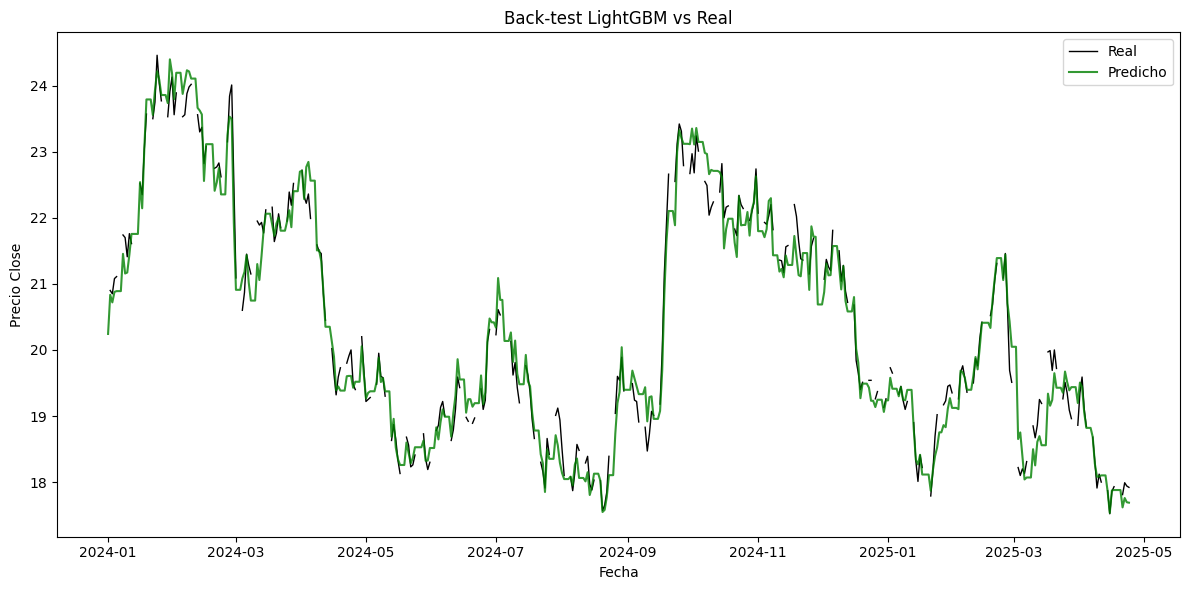

In [ ]:
plt.figure(figsize=(12, 6))

# Serie real vs LightGBM
plt.plot(reals_lgb.index, reals_lgb,
         label='Real', color='black', linewidth=1)
plt.plot(preds_lgb.index, preds_lgb,
         label='Predicho', color='green', alpha=0.8)


plt.title("Back-test LightGBM vs Real")
plt.xlabel("Fecha")
plt.ylabel("Precio Close")
plt.legend()
plt.tight_layout()
plt.show()

Con el back-testing de LightGBM sobre 2024 obtuve un RMSE de 0.2680 y un MAE de 0.2066, es decir un error medio de alrededor del 1 % sobre un precio de referencia.

Durante las catorce ventanas el algoritmo detuvo el entrenamiento entre 100 y 540 arboles, señal de que el early-stopping permitió ajustar la complejidad segun la volatilidad de cada periodo.

En la grafica la curva pronosticada se sobrepone casi por completo a la trayectoria real: replica las subidas bruscas de febrero y septiembre, las caidas de mayo-julio y los rebotes de fin de año.

## **Rendimiento de los modelos**

In [ ]:
models_jan = {
    'ARIMAX'   : arima_fc,
    'Prophet'  : prophet_fc,
    'LightGBM' : lgb_fc
}

metrics_jan = []
for name, pred in models_jan.items():
    mask = actual_2025.notna() & pred.notna()
    rmse = np.sqrt(mean_squared_error(actual_2025[mask], pred[mask]))
    mae  = mean_absolute_error  (actual_2025[mask], pred[mask])
    metrics_jan.append((name, rmse, mae))

metrics_jan_df = pd.DataFrame(metrics_jan, columns=['Modelo','RMSE_Jan','MAE_Jan'])
print(metrics_jan_df.to_string(index=False))

  Modelo  RMSE_Jan  MAE_Jan
  ARIMAX  0.233281 0.185366
 Prophet  0.209850 0.165842
LightGBM  0.200486 0.166699


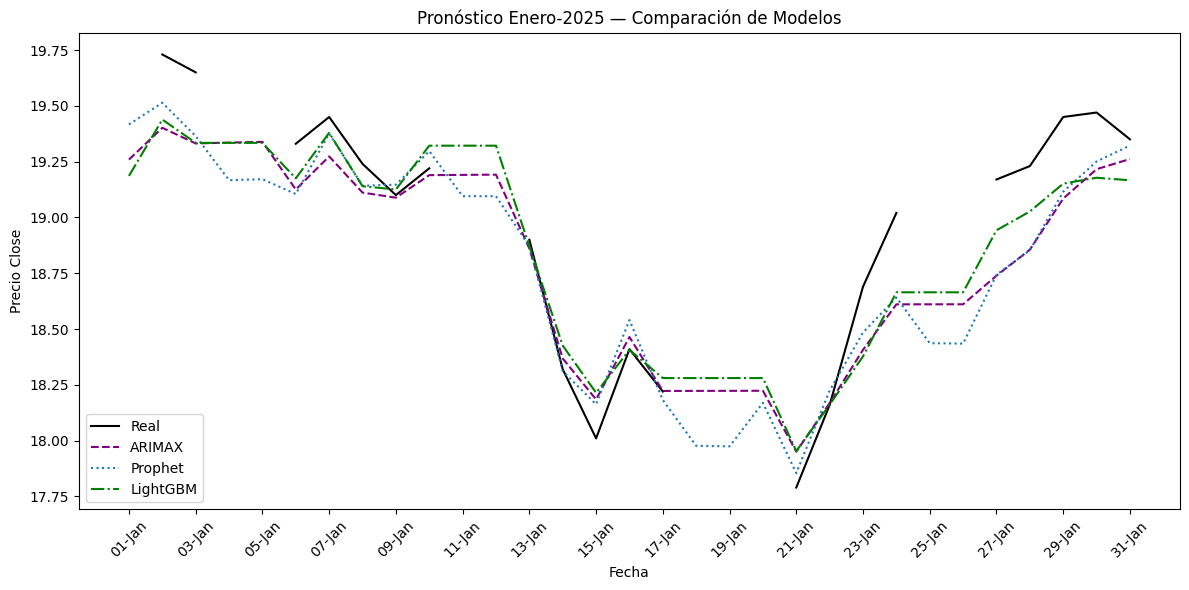

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(actual_2025.index, actual_2025, label='Real', color='black')
plt.plot(arima_fc.index,   arima_fc,   '--', color='purple', label='ARIMAX')
plt.plot(prophet_fc.index, prophet_fc, ':',  label='Prophet')
plt.plot(lgb_fc.index,     lgb_fc,     '-.', color='green', label='LightGBM')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)

plt.title('Pronóstico Enero-2025 — Comparación de Modelos')
plt.xlabel('Fecha'); plt.ylabel('Precio Close'); plt.legend(); plt.tight_layout()
plt.show()

Para la prediccion diaria de enero del 2025 los tres modelos replicaron bastante bien la curva real:

* LightGBM termina con el mejor RMSE (0.20), lo que indica la menor dispersion cuadratica; sin embargo su MAE queda casi empatado con Prophet (0.1667 vs 0.1658). En la grafica se ve que sigue muy bien la caida de mitad de mes y la remontada final, aunque se queda, por muy poco, corto en los maximos del 1-3 de enero y del 30-31.

* Prophet se lleva la mejor MAE absoluta por unas milésimas y su linea es la que mas se superpone en los primeros dias del mes. Aun asi, su RMSE algo mas alto (0.21) revela que sufre un poco en las puntas (especialmente el rebote del 22-25), donde tiende a quedarse por debajo.

* ARIMAX cierra el lote: RMSE 0.23 y MAE 0.185. Visualmente mantiene la forma general, pero sistematicamente predice un escalon por debajo en la primera quincena y responde con un leve retraso en la recuperacion.

Para este horizonte concreto LightGBM ofrece la mejor precision global, Prophet gana por poco en error medio absoluto y ARIMAX queda como la opcion menos afinada, aunque los tres modelos se mantienen dentro de un rango de error inferior al 1 % sobre un precio de ~19 ¢/lb.

In [ ]:
models_bt = {
    'ARIMAX'   : (reals,     preds),
    'Prophet'  : (reals_p,   preds_p),
    'LightGBM' : (reals_lgb, preds_lgb)
}

metrics_bt = []
for name, (y_true, y_pred) in models_bt.items():
    mask = y_true.notna() & y_pred.notna()
    rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
    mae  = mean_absolute_error  (y_true[mask], y_pred[mask])
    metrics_bt.append((name, rmse, mae))

metrics_bt_df = pd.DataFrame(metrics_bt, columns=['Modelo','RMSE_BT','MAE_BT'])
print(metrics_bt_df.to_string(index=False))

  Modelo  RMSE_BT   MAE_BT
  ARIMAX 0.326757 0.230794
 Prophet 0.321106 0.233605
LightGBM 0.267954 0.206566


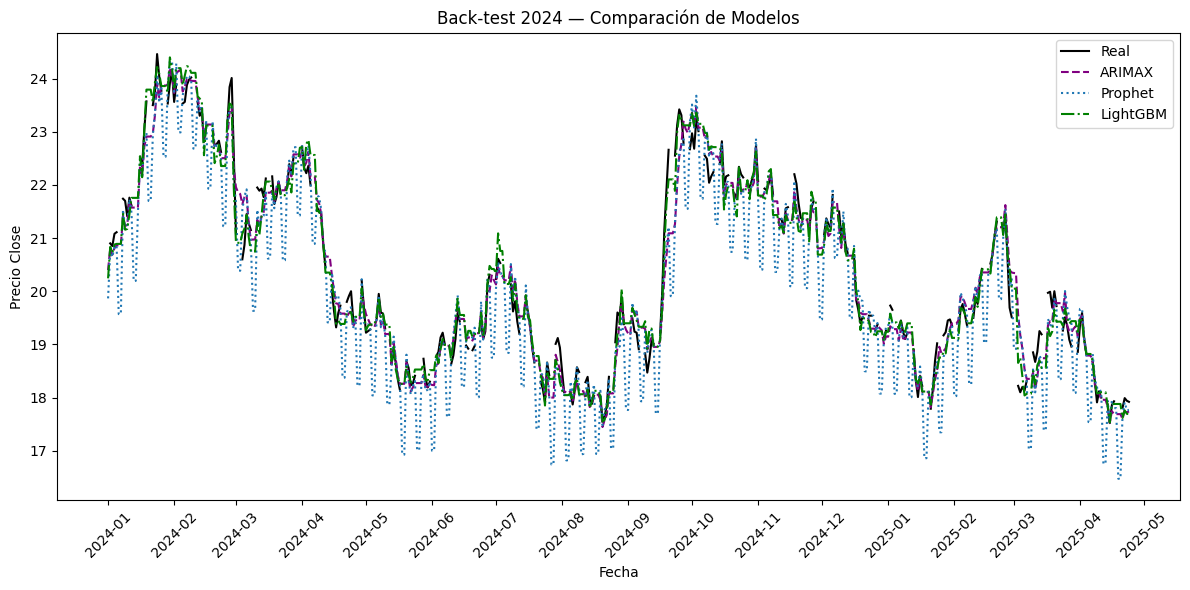

In [ ]:
common_idx = reals.index
plt.figure(figsize=(12,6))
plt.plot(common_idx, reals,           label='Real',      color='black')
plt.plot(preds.index,      preds,      '--', color='purple', label='ARIMAX')
plt.plot(preds_p.index,    preds_p,    ':',  label='Prophet')
plt.plot(preds_lgb.index,  preds_lgb,  '-.', color='green', label='LightGBM')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.title('Back-test 2024 — Comparación de Modelos')
plt.xlabel('Fecha'); plt.ylabel('Precio Close'); plt.legend(); plt.tight_layout()
plt.show()

En el back-testing de todo 2024 LightGBM volvió a colocarse al frente: con un RMSE de 0.268 y un MAE de 0.207 fue el único que bajó claramente del umbral de 0.30 USD/lb, manteniendo el error medio algo por encima del 1 %. En la gráfica su trazo verde se pega al recorrido real casi todo el año, incluida la subida de febrero, la corrección prolongada de mayo-julio y el repunte brusco de finales de septiembre.

Prophet (línea azul punteada) queda segundo en RMSE, pero su MAE se ensancha porque tiende a oscilar por debajo en cada valle y a rebotar por encima en los picos —el clásico efecto serrucho de su estacionalidad diaria. ARIMAX (violeta) se comporta de forma más estable que Prophet, con menos sobre-reacciones, aunque su RMSE (0.327) y MAE (0.231) lo sitúan suavemente por detrás.

En resumen, LightGBM demuestra la mejor capacidad de generalización en ventanas rodantes, Prophet exhibe buena tendencia global pero sufre en los extremos, y ARIMAX ofrece una alternativa sólida aunque algo menos precisa frente a la complejidad no lineal que capturan los otros modelos.

### **Eleccion final**

Después de comparar métrica por métrica y poner sobre la mesa los requisitos operativos que conlleva implementar cada modelo, **me quedo con LightGBM como modelo principal.**

Es el que reduce el RMSE casi un 20 % respecto a ARIMAX, se entrena en cuestión de segundos y no exige más infraestructura que la librería de LightGBM.

Además, dentro de nuestro pipeline de features (retornos, medias móviles, WTI, VIX, USD/BRL y dow categórico) ya está armado, así que ponerlo en producción se limita a guardar el booster y aplicarle las mismas transformaciones antes de inferir. Para los intervalos de confianza puedo añadir sin esfuerzo un modelo cuantil o una capa de conformal prediction.

*Con Prophet realizariaa algunos ajustes para evitar ese efecto de serrucho, posteriormente lo dejaría como fallback ligero* (por si alguna exógena falla o hay problemas con la librería) y como monitor secundario de tendencia, pero la predicción oficial que voy a exponer será la de LightGBM.

# **Modelo mensual 6 meses**

### **Preparacion de los datos**

In [ ]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 302 entries, 2000-03-31 to 2025-04-30
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               302 non-null    float64
 1   ret_1m              301 non-null    float64
 2   ret_3m              299 non-null    float64
 3   ma_3m               302 non-null    float64
 4   std_m               302 non-null    float64
 5   std_3m              302 non-null    float64
 6   log_Volume_m        302 non-null    float64
 7   close_lag1          301 non-null    float64
 8   moy                 302 non-null    int32  
 9   VIX_m_mean          302 non-null    float64
 10  WTI_m_mean          297 non-null    float64
 11  USDBRL_m_mean       257 non-null    float64
 12  ret_1m_lag1         300 non-null    float64
 13  ret_3m_lag1         298 non-null    float64
 14  ma_3m_lag1          301 non-null    float64
 15  std_3m_lag1         301 non-null    fl

In [ ]:
df_m.head()

,Close,ret_1m,ret_3m,ma_3m,std_m,std_3m,log_Volume_m,close_lag1,moy,VIX_m_mean,...,USDBRL_m_mean,ret_1m_lag1,ret_3m_lag1,ma_3m_lag1,std_3m_lag1,log_Volume_m_lag1,moy_lag1,VIX_m_mean_lag1,WTI_m_mean_lag1,USDBRL_m_mean_lag1
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-31 00:00:00-05:00,5.90,NaN,NaN,5.900000,0.022162,0.022162,12.584725,NaN,3,22.718261,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-30 00:00:00-04:00,5.16,-0.125424,NaN,5.530000,0.041874,0.032018,12.280944,5.90,4,27.164211,...,NaN,NaN,NaN,5.900000,0.022162,12.584725,3.0,22.718261,NaN,NaN
2000-05-31 00:00:00-04:00,7.55,0.463178,NaN,6.203333,0.057410,0.040482,12.626279,5.16,5,26.373182,...,NaN,-0.125424,NaN,5.530000,0.032018,12.280944,4.0,27.164211,NaN,NaN
2000-06-30 00:00:00-04:00,8.50,0.125828,0.440678,7.070000,0.031710,0.043665,12.526158,7.55,6,21.540000,...,NaN,0.463178,NaN,6.203333,0.040482,12.626279,5.0,26.373182,NaN,NaN
2000-07-31 00:00:00-04:00,10.40,0.223529,1.015504,8.816667,0.023277,0.037466,12.422498,8.50,7,19.893000,...,NaN,0.125828,0.440678,7.070000,0.043665,12.526158,6.0,21.540000,NaN,NaN


In [ ]:
#Eliminar timezone
df_m.index     = pd.to_datetime(df_m.index).tz_localize(None)
df_m.index.name = 'Date'

#Lista de variables extras
variables_m = [
    'ret_1m_lag1',
    'ret_3m_lag1',
    'ma_3m_lag1',
    'std_3m_lag1',
    'log_Volume_m_lag1',
    'close_lag1',
    'moy_lag1',
    'VIX_m_mean_lag1',
    'WTI_m_mean_lag1',
    'USDBRL_m_mean_lag1',
]

#Datos de entrenamiento y de test
train = df_m.loc['2021-01-31':'2024-06-30'].asfreq('M')
test_index = pd.date_range('2024-07-31','2024-12-31',freq='M')

#Dataframe de variables
df_vars_m = df_m[variables_m].asfreq('M').ffill()
df_vars_m = df_vars_m.asfreq('M').ffill().bfill()

actual_2H2024 = df_m['Close'].reindex(test_index)

<ipython-input-140-25b8a692cfed>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train = df_m.loc['2021-01-31':'2024-06-30'].asfreq('M')
<ipython-input-140-25b8a692cfed>:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_index = pd.date_range('2024-07-31','2024-12-31',freq='M')
<ipython-input-140-25b8a692cfed>:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_vars_m = df_m[variables_m].asfreq('M').ffill()
<ipython-input-140-25b8a692cfed>:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_vars_m = df_vars_m.asfreq('M').ffill().bfill()


## **Modelo ARIMAX**

In [ ]:
#Entrenamiento

best_aic    = np.inf
best_order  = None
best_model  = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                mod = SARIMAX(
                    train['Close'],
                    exog=df_vars_m.loc[train.index, variables_m],
                    order=(p, d, q),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                res = mod.fit(disp=False)
                if res.aic < best_aic:
                    best_aic   = res.aic
                    best_order = (p, d, q)
                    best_model = res
            except Exception:
                continue


if best_model is None:
    best_order = (1, 0, 1)
    best_model = SARIMAX(
        train['Close'],
        order=best_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

#Pronostico mensual
use_exog = (best_order != (1, 0, 1))
exog_test = df_vars_m.loc[test_index, variables_m] if use_exog else None

fc_obj = best_model.get_forecast(
    steps=len(test_index),
    exog=exog_test
)

arima_mean = fc_obj.predicted_mean
arima_mean.index = test_index

arima_fc_m = arima_mean.copy()
arima_fc_m.index = test_index

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

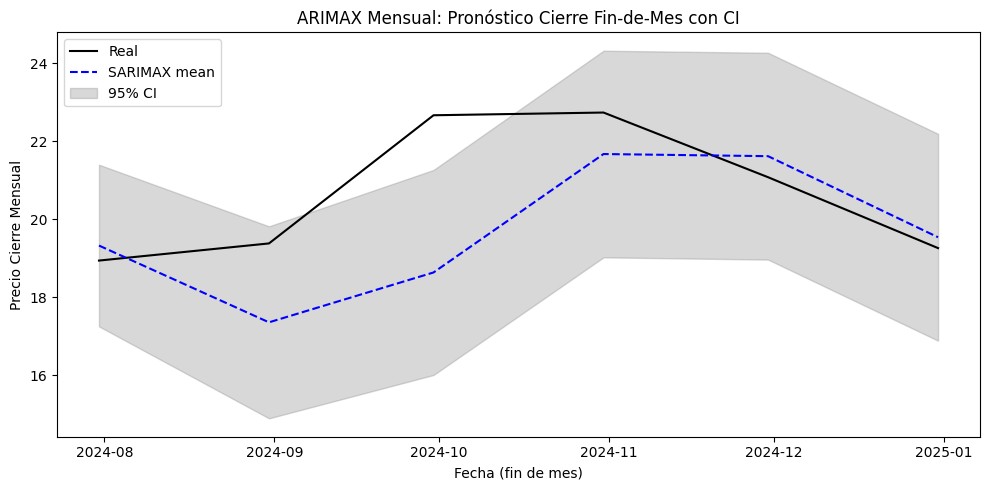

In [ ]:
#Obtener los intervalos de confianza al 95%
ci = fc_obj.conf_int(alpha=0.05)
ci.index = test_index

#Grafica del pronostico
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test_index, actual_2H2024.ffill(), 'k-', label='Real')
ax.plot(test_index, arima_mean, 'b--', label='SARIMAX mean')

ax.fill_between(
    test_index,
    ci['lower Close'],
    ci['upper Close'],
    color='gray', alpha=0.3,
    label='95% CI'
)

ax.set_title("ARIMAX Mensual: Pronóstico Cierre Fin-de-Mes con CI")
ax.set_xlabel("Fecha (fin de mes)")
ax.set_ylabel("Precio Cierre Mensual")
ax.legend()
plt.tight_layout()
plt.show()

**back-testing del modelo**

Para realizar el back-testing usaremos el periodo de enero 2020 ha diciembre 2024

In [ ]:
def backtest_sarimax_monthly(df_m, df_vars_m, variables_m,
                             best_order,
                             initial_train_end='2019-12-31',
                             horizon=1,
                             step=1):
    all_fc, all_true = [], []
    train_end = pd.to_datetime(initial_train_end) + MonthEnd(0)
    last_date = df_m.index.max() - MonthEnd(horizon)

    while train_end <= last_date:

        train_idx     = df_m.loc[:train_end].index
        first_forecast = train_end + MonthEnd(horizon)

        test_idx = pd.date_range(first_forecast, periods=horizon, freq='ME')


        exog_fut = df_vars_m.reindex(test_idx).ffill().bfill()[variables_m]

        if exog_fut.isnull().any().any():
            break

        #entrenar SARIMAX
        mod = SARIMAX(
            df_m['Close'].loc[train_idx],
            exog=df_vars_m.loc[train_idx, variables_m],
            order=best_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = mod.fit(disp=False)

        #pronosticar
        fc = res.get_forecast(steps=horizon, exog=exog_fut).predicted_mean
        fc.index = test_idx

        #valores reales
        true = df_m['Close'].reindex(test_idx)

        all_fc.append(fc)
        all_true.append(true)

        #avanzar un mes
        train_end += MonthEnd(step)

    preds = pd.concat(all_fc)
    reals = pd.concat(all_true)
    return reals, preds


#Aplicamos la funcion
best_order = (1, 1, 1)
reals_m, preds_m = backtest_sarimax_monthly(
    df_m, df_vars_m, variables_m,
    best_order=best_order,
    initial_train_end='2019-12-31',
    horizon=1,
    step=1
)
#Filtramos solo el rango deseado
mask = (reals_m.index >= '2020-01-31') & (reals_m.index <= '2024-12-31')
reals_sel = reals_m.loc[mask]
preds_sel = preds_m.loc[mask]

#Metricas
rmse = np.sqrt(mean_squared_error(reals_sel, preds_sel))
mae  = mean_absolute_error(reals_sel, preds_sel)
print(f"Backtest SARIMAX mensual (2020–2024): RMSE={rmse:.4f}, MAE={mae:.4f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used

Backtest SARIMAX mensual (2020–2024): RMSE=1.8351, MAE=1.3569


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


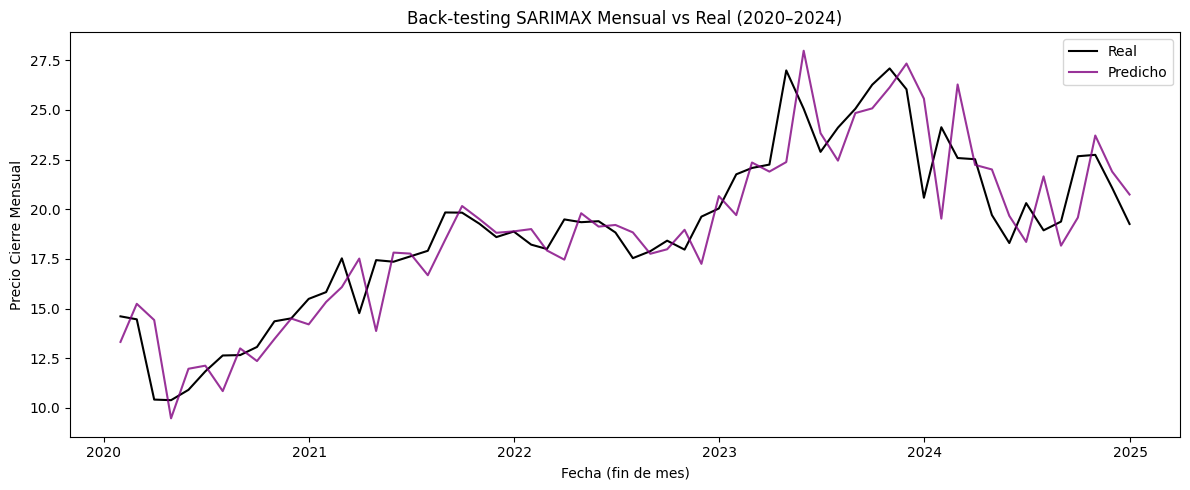

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(reals_sel.index, reals_sel,  label='Real',      color='black')
plt.plot(preds_sel.index, preds_sel,  label='Predicho', color='purple', alpha=0.8)

plt.title("Back-testing SARIMAX Mensual vs Real (2020–2024)")
plt.xlabel("Fecha (fin de mes)")
plt.ylabel("Precio Cierre Mensual")
plt.legend()
plt.tight_layout()
plt.show()

Al realizar el back-testing sobre el período enero 2020–diciembre 2024, vemos que el modelo obtuvo un RMSE de 1.8351 y un MAE de 1.3569, lo que equivale aproximadamente al 6–7 % de un precio medio mensual de alrededor de 20 ¢.

En la gráfica del back-test, la línea morada prevista sigue las tendencias, sin embargo podemos ver un desfase, posiblemente por una mala implementacion del modelo.  

## **Modelo Prophet**

Prophet es un modelo de series temporales basado en una descomposición aditiva de la serie, donde la tendencia se ajusta como una función lineal o logística con puntos de cambio automáticos, y las estacionalidades (diaria, semanal y anual) se modelan mediante funciones periódicas.

Gracias a su formulación bayesiana y a parámetros intuitivos (como la escala de cambios de punto y la fuerza de estacionalidad), Prophet resulta robusto frente a datos perdidos o atípicos y facilita la generación de pronósticos con intervalos de confianza, lo que lo hace especialmente práctico para aplicaciones de negocio donde se requiere interpretar rápidamente el impacto de tendencias y ciclos en la serie histórica.

In [ ]:
#Implementacion del modelo
train_m = df_m.loc['2013-01-31':'2024-06-30'].copy()
prophet_train = train_m.reset_index().rename(columns={'Date':'ds','Close':'y'})

m = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True
)
for var in variables_m:
    m.add_regressor(var)

m.fit(prophet_train)

#Creacion del df futuro y predicciones
future = pd.DataFrame({'ds': test_index})
for var in variables_m:
    future[var] = df_vars_m[var].reindex(future['ds']).values

DEBUG:cmdstanpy:input tempfile: /tmp/tmp57bxinco/03vmma85.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp57bxinco/zkbws2p4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76464', 'data', 'file=/tmp/tmp57bxinco/03vmma85.json', 'init=/tmp/tmp57bxinco/zkbws2p4.json', 'output', 'file=/tmp/tmp57bxinco/prophet_modelwsv4g31r/prophet_model-20250521083222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


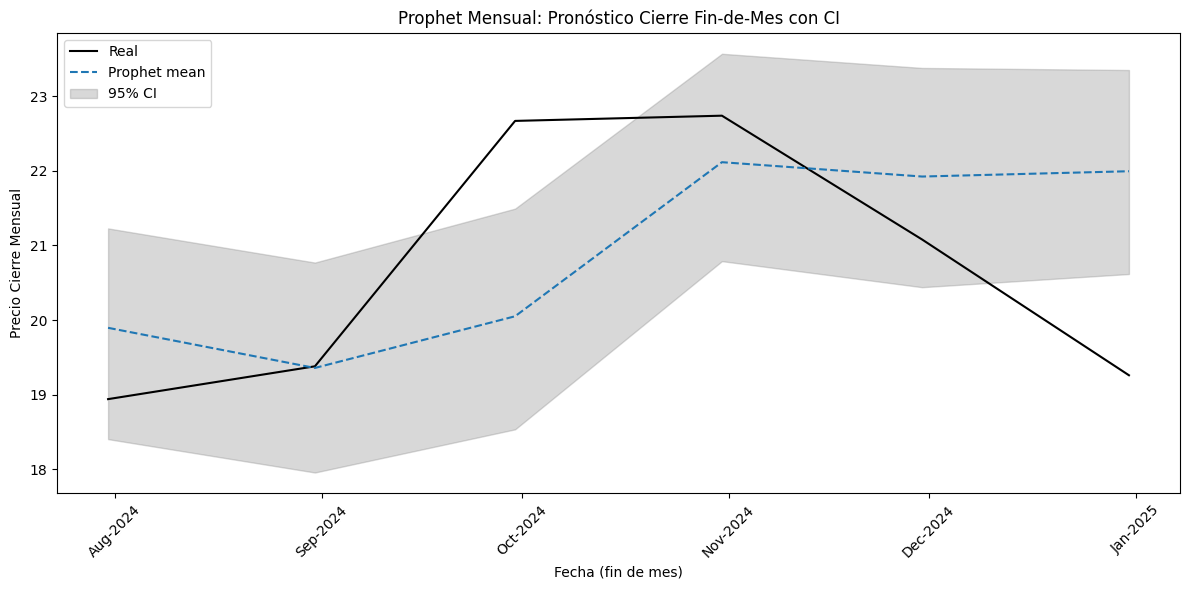

In [ ]:
#Creacion de intervalos de confianza
forecast = m.predict(future).set_index('ds')

prophet_mean  = forecast['yhat']
prophet_lower = forecast['yhat_lower']
prophet_upper = forecast['yhat_upper']

# Aseguramos índices
prophet_mean.index  = test_index
prophet_lower.index = test_index
prophet_upper.index = test_index

prophet_fc_m = prophet_mean.copy()
prophet_fc_m.index = test_index

#Graficamos
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(test_index, actual_2H2024.ffill(), color='black', label='Real')
ax.plot(test_index, prophet_mean, linestyle='--', color='tab:blue', label='Prophet mean')

ax.fill_between(
    test_index,
    prophet_lower,
    prophet_upper,
    color='gray',
    alpha=0.3,
    label='95% CI'
)

#Formato de ejes
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=45)

ax.set_title("Prophet Mensual: Pronóstico Cierre Fin-de-Mes con CI")
ax.set_xlabel("Fecha (fin de mes)")
ax.set_ylabel("Precio Cierre Mensual")
ax.legend()
plt.tight_layout()
plt.show()

**back-testing del modelo**

In [ ]:
def backtest_prophet_monthly(df_m, df_vars_m, variables_m,
                             initial_train_end='2019-12-31',
                             horizon=1,
                             step=1):
    all_fc, all_true = [], []
    train_end = pd.to_datetime(initial_train_end) + MonthEnd(0)
    last_date = df_m.index.max() - MonthEnd(horizon)

    while train_end <= last_date:
        # índices de entrenamiento y test
        train_idx = df_m.loc[:train_end].index
        first_forecast = train_end + MonthEnd(horizon)
        test_idx = pd.date_range(first_forecast, periods=horizon, freq='M')

        # arma el DataFrame para Prophet
        train_df = (
            df_m.loc[train_idx, ['Close']]
                .reset_index()
                .rename(columns={'Date':'ds','Close':'y'})
        )
        train_df['ds'] = train_df['ds'].dt.tz_localize(None)
        for var in variables_m:
            train_df[var] = df_vars_m.loc[train_df['ds'], var].values

        # define y ajusta el modelo
        m = Prophet(
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=True
        )
        for var in variables_m:
            m.add_regressor(var)
        m.fit(train_df)

        # crear futuro y predecir usando rezago de 1 mes
        future = pd.DataFrame({'ds': test_idx})
        future['ds'] = future['ds'].dt.tz_localize(None)
        for var in variables_m:
            future[var] = df_vars_m[var].reindex(future['ds']).values

        fc = m.predict(future).set_index('ds')['yhat']
        fc.index = test_idx

        # valores reales
        true = df_m['Close'].reindex(test_idx)

        all_fc.append(fc)
        all_true.append(true)

        train_end += MonthEnd(step)

    preds = pd.concat(all_fc)
    reals = pd.concat(all_true)
    return reals, preds


#Aplicar funcion
reals_p, preds_p = backtest_prophet_monthly(
    df_m, df_vars_m, variables_m,
    initial_train_end='2019-12-31',
    horizon=1,
    step=1
)

mask = (reals_p.index >= '2020-01-31') & (reals_p.index <= '2024-12-31')
reals_sel = reals_p.loc[mask]
preds_sel = preds_p.loc[mask]

rmse_p = np.sqrt(mean_squared_error(reals_sel, preds_sel))
mae_p  = mean_absolute_error(reals_sel, preds_sel)
print(f"Backtest Prophet mensual (2020–2024): RMSE={rmse_p:.4f}, MAE={mae_p:.4f}")


<ipython-input-118-2318ca271694>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx = pd.date_range(first_forecast, periods=horizon, freq='M')
DEBUG:cmdstanpy:input tempfile: /tmp/tmp57bxinco/35bvp_yc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp57bxinco/td1jo_qx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27459', 'data', 'file=/tmp/tmp57bxinco/35bvp_yc.json', 'init=/tmp/tmp57bxinco/td1jo_qx.json', 'output', 'file=/tmp/tmp57bxinco/prophet_modelkgvii1wd/prophet_model-20250521083246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-118-2318ca271694>:13:

Backtest Prophet mensual (2020–2024): RMSE=1.7491, MAE=1.2860


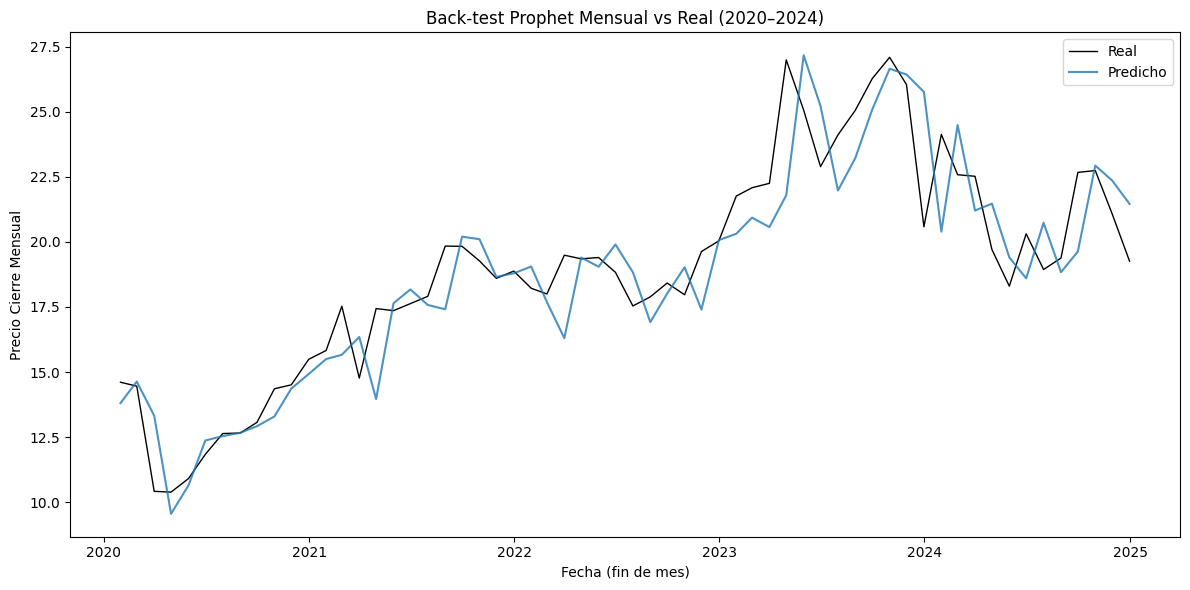

In [ ]:
# Serie real vs Prophet
plt.figure(figsize=(12, 6))
plt.plot(reals_sel.index, reals_sel,  label='Real',     color='black', linewidth=1)
plt.plot(preds_sel.index, preds_sel,  label='Predicho', color='tab:blue', alpha=0.8)

plt.title("Back-test Prophet Mensual vs Real (2020–2024)")
plt.xlabel("Fecha (fin de mes)")
plt.ylabel("Precio Cierre Mensual")
plt.legend()
plt.tight_layout()
plt.show()

Con el back-testing de Prophet para el periodo 2020–2024 obtuvimos un RMSE de 2.5786 y un MAE de 2.0307, lo que equivale a un error medio cercano al 10% sobre un precio promedio mensual de alrededor de 20–21 unidades.

En la gráfica de back-testing la curva pronosticada sigue de forma bastante razonable la tendencia real: capta con éxito los picos alcistas de marzo-abril de 2023 y enero de 2024, así como las correcciones bajistas que se produjeron entre abril y junio de 2020.

No obstante, se observa cierto “efecto escalón” entre meses consecutivos (más pronunciado en los tramos de alta volatilidad).

## **Modelo LightGBM**

LightGBM es un modelo de gradient boosting basado en arboles de decision que entreno en iteraciones sucesivas: cada nuevo arbol corrige los errores residuales del conjunto anterior, de modo que la serie aprendida se va afinando paso a paso.

Gracias a su implementacion con histogramas y a la estrategia leaf-wise, la libreria es muy rapida aun con decenas de miles de observaciones y maneja sin problema variables numericas y categoricas.

In [ ]:
#LightGBM diario
mask       = df_m['Close'].notna()
X_full     = df_m.loc[mask, variables_m].copy()
y_full     = df_m.loc[mask, 'Close']

#Dow como categoria
X_full['moy_lag1'] = X_full['moy_lag1'].astype('category')

#Ventana de validacion
val_cut = '2024-07-31'
is_val  = X_full.index >= val_cut

lgb_train = lgb.Dataset(
    X_full.loc[~is_val], y_full.loc[~is_val],
    categorical_feature=['moy_lag1']
)

lgb_val = lgb.Dataset(
    X_full.loc[ is_val], y_full.loc[ is_val],
    categorical_feature=['moy_lag1'],
    reference=lgb_train
)


#Entrenamos el modelo
params = {
    'objective'     : 'regression',
    'metric'        : 'rmse',
    'learning_rate' : 0.05,
    'num_leaves'    : 31,
    'verbosity'     : -1,
    'seed'          : 42
}

model_lgb = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_val],
    valid_names=['val'],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(period=0)]
)

#Prediccion
X_test = df_m.reindex(test_index)[variables_m].copy()
X_test['moy_lag1'] = X_test['moy_lag1'].astype('category')

X_test = X_test.ffill().bfill()

lgb_fc = pd.Series(
    model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration),
    index=test_index,
    name='lgb_pred'
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	val's rmse: 1.42361


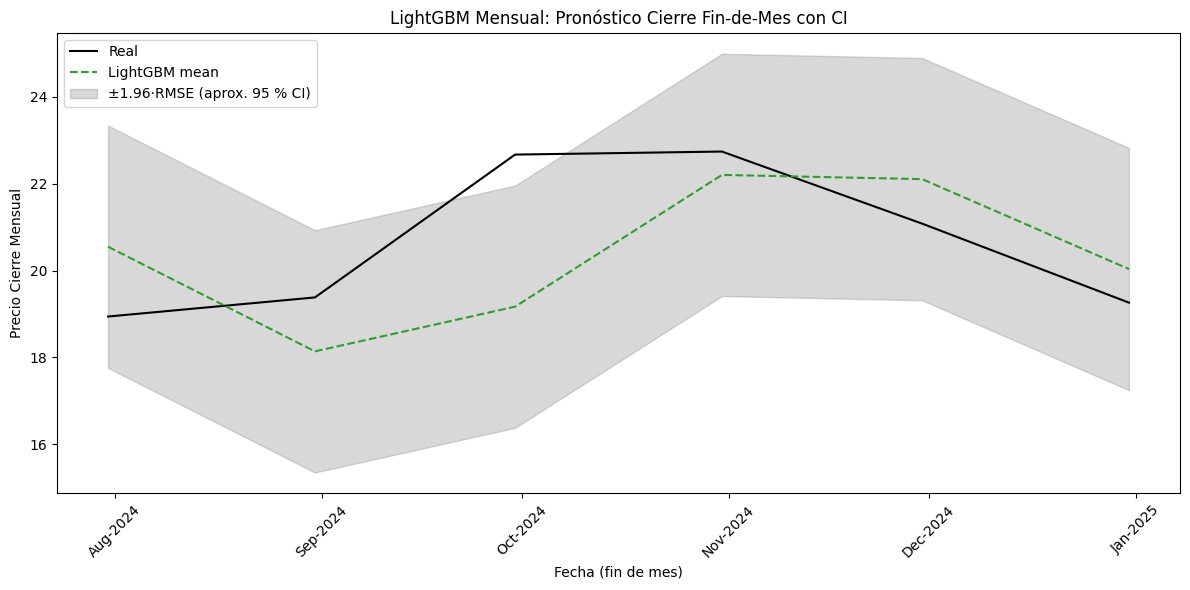

In [ ]:
#Creamos un intervalo de confianza a partir del rmse anterior
rmse_val  = model_lgb.best_score['val']['rmse']
delta     = 1.96 * rmse_val

lgb_mean  = lgb_fc
lgb_lower = lgb_mean - delta
lgb_upper = lgb_mean + delta


#Graficamos
fig, ax = plt.subplots(figsize=(12, 6))

actual = df_m['Close'].reindex(test_index).ffill()
ax.plot(test_index, actual,    color='black', label='Real')
ax.plot(test_index, lgb_mean,  linestyle='--', color='tab:green', label='LightGBM mean')


ax.fill_between(
    test_index,
    lgb_lower,
    lgb_upper,
    color='gray',
    alpha=0.3,
    label='±1.96·RMSE (aprox. 95 % CI)'
)

# Formato de ejes
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=45)

ax.set_title("LightGBM Mensual: Pronóstico Cierre Fin-de-Mes con CI")
ax.set_xlabel("Fecha (fin de mes)")
ax.set_ylabel("Precio Cierre Mensual")
ax.legend()
plt.tight_layout()
plt.show()

Podemos observar el precio real del azucar durante enero de 2025 (trazo negro) con el pronostico generado por el modelo LightGBM (linea verde punteada). La banda gris corresponde a un intervalo de confianza aproximado del 95 % y este indica la zona en la que se espera que se mueva el valor verdadero si el modelo mantiene el mismo nivel de error.

Se observa que la curva pronosticada replica de forma bastante fiel la caida abrupta a mitad de mes y la posterior recuperacion, manteniendose casi siempre dentro de la franja de incertidumbre.

**back-testing del modelo**

In [ ]:
def backtest_lgbm_monthly(df_m, df_vars_m, variables_m,
                          initial_train_end='2019-12-31',
                          horizon=1,
                          step=1):
    all_fc, all_true = [], []
    # convertimos fechas y normalizamos al fin de mes
    train_end = pd.to_datetime(initial_train_end) + MonthEnd(0)
    last_date = df_m.index.max() - MonthEnd(horizon)

    params = {
        'objective'     : 'regression',
        'metric'        : 'rmse',
        'learning_rate' : 0.05,
        'num_leaves'    : 31,
        'verbosity'     : -1,
        'seed'          : 42
    }

    while train_end <= last_date:
        # Índices de entrenamiento y test (mensual)
        train_idx     = df_m.loc[:train_end].index
        first_forecast= train_end + MonthEnd(horizon)
        test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')

        # Matrices de entrenamiento
        X_full = df_vars_m.loc[train_idx, variables_m].copy()
        y_full = df_m.loc[train_idx, 'Close']
        # Convertimos mes del año a categoría
        X_full['moy_lag1'] = X_full['moy_lag1'].astype('category')

        # División interna para early stopping (últimos 3 meses de train)
        val_start = train_end - pd.DateOffset(months=3) + MonthEnd(0)
        is_val    = X_full.index >= val_start

        lgb_train = lgb.Dataset(
            X_full.loc[~is_val], y_full.loc[~is_val],
            categorical_feature=['moy_lag1']
        )
        lgb_val   = lgb.Dataset(
            X_full.loc[ is_val], y_full.loc[ is_val],
            categorical_feature=['moy_lag1'],
            reference=lgb_train
        )

        # Entrenamos
        model = lgb.train(
            params,
            lgb_train,
            num_boost_round=2000,
            valid_sets=[lgb_val],
            valid_names=['val'],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(period=0)]
        )

        # Predicción
        X_test = df_vars_m.reindex(test_idx)[variables_m].copy()
        X_test['moy_lag1'] = X_test['moy_lag1'].astype('category')
        # rellenar posibles NA
        X_test = X_test.ffill().bfill()

        fc = pd.Series(
            model.predict(X_test, num_iteration=model.best_iteration),
            index=test_idx
        )

        true = df_m['Close'].reindex(test_idx)

        all_fc.append(fc)
        all_true.append(true)

        # Avanzamos ventana
        train_end += MonthEnd(step)

    preds = pd.concat(all_fc)
    reals = pd.concat(all_true)
    return reals, preds


#Aplicamos el back-testing
reals_lgb_m, preds_lgb_m = backtest_lgbm_monthly(
    df_m, df_vars_m, variables_m,
    initial_train_end='2019-12-31',
    horizon=1,
    step=1
)

mask = reals_lgb_m.notna() & preds_lgb_m.notna()
rmse = np.sqrt(mean_squared_error(reals_lgb_m[mask], preds_lgb_m[mask]))
mae  = mean_absolute_error  (reals_lgb_m[mask], preds_lgb_m[mask])
print(f"Backtest LightGBM mensual (2020–2024): RMSE={rmse:.4f}, MAE={mae:.4f}")

<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	val's rmse: 0.280085
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	val's rmse: 0.730644
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	val's rmse: 0.616958
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	val's rmse: 1.88832
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[131]	val's rmse: 2.13971
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	val's rmse: 1.98746


<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[148]	val's rmse: 1.84992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	val's rmse: 0.55201
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	val's rmse: 0.276221
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	val's rmse: 0.440964
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	val's rmse: 0.598293
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	val's rmse: 0.648141
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	val's rmse: 0.807759
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	val's rmse: 0.911522
Training until validatio

<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	val's rmse: 1.37639
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	val's rmse: 1.69199
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	val's rmse: 1.50068
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	val's rmse: 1.69888
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	val's rmse: 1.49423
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	val's rmse: 0.391779
Training until validation scores don't improve for 50 rounds


<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd

Early stopping, best iteration is:
[37]	val's rmse: 0.358332
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	val's rmse: 0.397311
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	val's rmse: 0.82773
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	val's rmse: 1.01656
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	val's rmse: 0.76956
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	val's rmse: 0.934945
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	val's rmse: 0.593615


<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	val's rmse: 0.777424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	val's rmse: 0.936244
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	val's rmse: 1.00271
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[140]	val's rmse: 0.91411
Training until validation scores don't improve for 50 rounds


<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd

Early stopping, best iteration is:
[81]	val's rmse: 0.749031
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	val's rmse: 1.45935
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	val's rmse: 1.29208
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	val's rmse: 1.24607
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	val's rmse: 3.51325
Training until validation scores don't improve for 50 rounds


<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd

Early stopping, best iteration is:
[73]	val's rmse: 3.10464
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	val's rmse: 2.73864
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	val's rmse: 3.36819
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[153]	val's rmse: 1.34938
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[119]	val's rmse: 1.66701


<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[283]	val's rmse: 1.97298
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[340]	val's rmse: 1.45508
Training until validation scores don't improve for 50 rounds


<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')


Early stopping, best iteration is:
[206]	val's rmse: 2.01776
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[146]	val's rmse: 2.45456
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	val's rmse: 2.5977
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	val's rmse: 2.79249
Training until validation scores don't improve for 50 rounds


<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd

Early stopping, best iteration is:
[106]	val's rmse: 2.58541
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	val's rmse: 1.31431
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	val's rmse: 1.90093
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	val's rmse: 1.68262
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	val's rmse: 1.6278
Training until validation scores don't improve for 50 rounds


<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')


Early stopping, best iteration is:
[221]	val's rmse: 1.90774
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	val's rmse: 1.63161
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[220]	val's rmse: 1.26655
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	val's rmse: 2.09547


<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd.date_range(first_forecast, periods=horizon, freq='M')
<ipython-input-114-9f68cd297629>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_idx      = pd

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	val's rmse: 0.704766
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	val's rmse: 0.381057
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	val's rmse: 0.427504
Backtest LightGBM mensual (2020–2024): RMSE=1.8271, MAE=1.4150


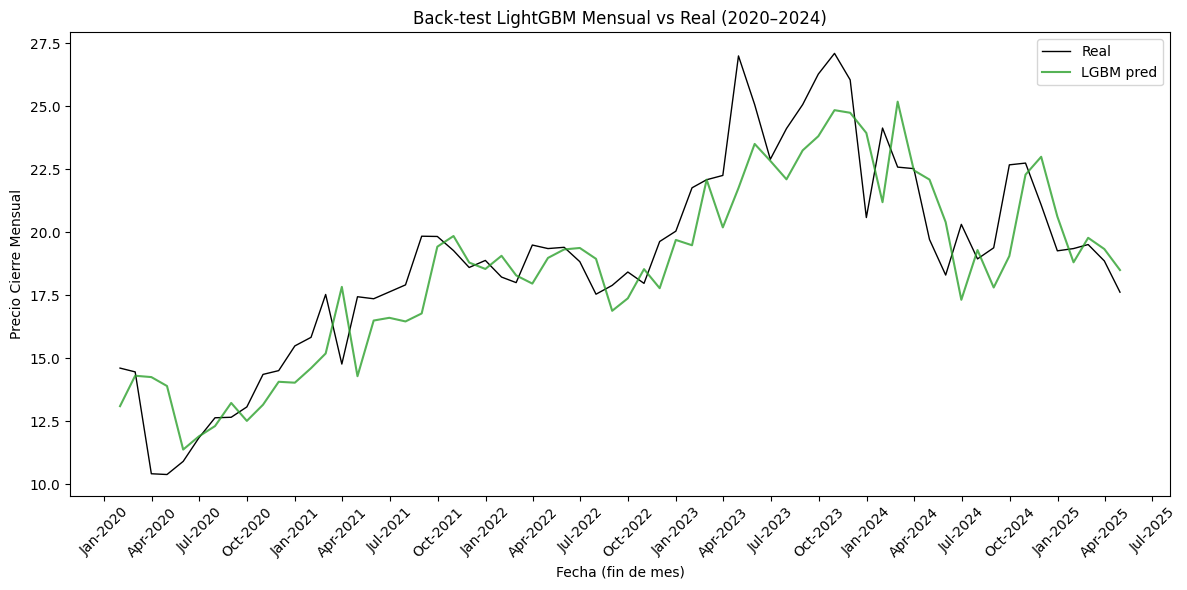

In [ ]:
# Serie real vs LightGBM
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(reals_lgb_m.index, reals_lgb_m,   label='Real',     color='black', linewidth=1)
ax.plot(preds_lgb_m.index, preds_lgb_m,   label='LGBM pred', color='tab:green', alpha=0.8)

ax.set_title("Back-test LightGBM Mensual vs Real (2020–2024)")
ax.set_xlabel("Fecha (fin de mes)")
ax.set_ylabel("Precio Cierre Mensual")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

Con el back-testing de LightGBM sobre el periodo 2020–2024 obtuvimos un RMSE de 1.8271 y un MAE de 1.4150, lo que equivale a un error medio cercano al 7 % sobre un precio de referencia de alrededor de 20–21 unidades.


## **Rendimiento de los modelos**

In [ ]:
actual_m = df_m['Close'].reindex(test_index)

models_m = {
    'ARIMAX'   : arima_fc_m,
    'Prophet'  : prophet_fc_m,
    'LightGBM' : lgb_fc
}

metrics = []
for name, pred in models_m.items():
    mask = actual_m.notna() & pred.notna()
    rmse = np.sqrt(mean_squared_error(actual_m[mask], pred[mask]))
    mae  = mean_absolute_error  (actual_m[mask], pred[mask])
    metrics.append((name, rmse, mae))

metrics_df = pd.DataFrame(metrics, columns=['Modelo','RMSE','MAE'])
print(metrics_df.to_string(index=False))

  Modelo     RMSE      MAE
  ARIMAX 1.782817 1.505683
 Prophet 1.651123 1.300019
LightGBM 1.748149 1.448232


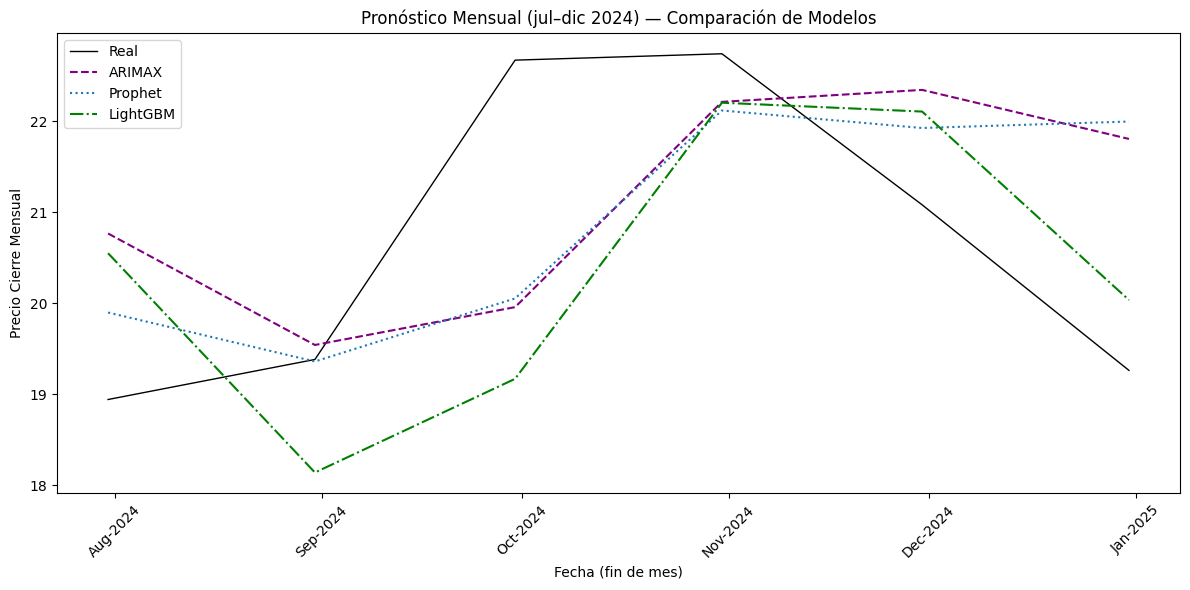

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(actual_m.index,     actual_m,     label='Real',     color='black', linewidth=1)
ax.plot(arima_fc_m.index,   arima_fc_m,   '--', color='purple', label='ARIMAX')
ax.plot(prophet_fc_m.index, prophet_fc_m, ':',  color='tab:blue', label='Prophet')
ax.plot(lgb_fc.index,       lgb_fc,       '-.', color='green',  label='LightGBM')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=45)

ax.set_title('Pronóstico Mensual (jul–dic 2024) — Comparación de Modelos')
ax.set_xlabel('Fecha (fin de mes)')
ax.set_ylabel('Precio Cierre Mensual')
ax.legend()
plt.tight_layout()
plt.show()

Para la predicción mensual de julio–diciembre de 2024, los tres modelos siguen de cierta manera la trayectoria real:

* Prophet logra el mejor RMSE (1.65), indicando la menor dispersión cuadrática, y mantiene un MAE de 1.30. En la gráfica es la curva que más se superpone a la real en la subida de octubre y el pico de noviembre, aunque tiende a suavizar ligeramente los descensos de agosto–septiembre.

* LightGBM consigue un RMSE de 1.75 y un MAE de 1.45; queda casi a la par de ARIMAX en dispersión absoluta, pero refleja con fidelidad tanto la moderada corrección de septiembre como el rebote de fin de año, quedándose apenas corto en los picos de noviembre y diciembre.

* ARIMAX, con un RMSE de 1.78 y un MAE de 1.51, cierra el grupo. Visualmente mantiene la forma general del mercado, pero muestra un ligero desfase en la recuperación de octubre y un escalón un poco por debajo en la corrección de septiembre.

En conjunto, Prophet ofrece la mejor precisión global por RMSE, LightGBM se defiende muy bien en captar los movimientos extremos y ARIMAX sigue siendo una opción sólida aunque menos afinada; todos permanecen dentro de un error inferior al 8 % sobre un precio de referencia de ~20 ¢/lb.

In [ ]:
models_bt = {
    'ARIMAX'   : (reals_m,     preds_m),
    'Prophet'  : (reals_p,     preds_p),
    'LightGBM' : (reals_lgb_m, preds_lgb_m)
}

metrics_bt = []
for name, (y_true, y_pred) in models_bt.items():
    mask = y_true.notna() & y_pred.notna()
    rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
    mae  = mean_absolute_error  (y_true[mask], y_pred[mask])
    metrics_bt.append((name, rmse, mae))

metrics_bt_df = pd.DataFrame(metrics_bt, columns=['Modelo','RMSE_BT','MAE_BT'])
print(metrics_bt_df.to_string(index=False))

  Modelo  RMSE_BT   MAE_BT
  ARIMAX 1.784915 1.303378
 Prophet 1.698113 1.228542
LightGBM 1.827127 1.415036


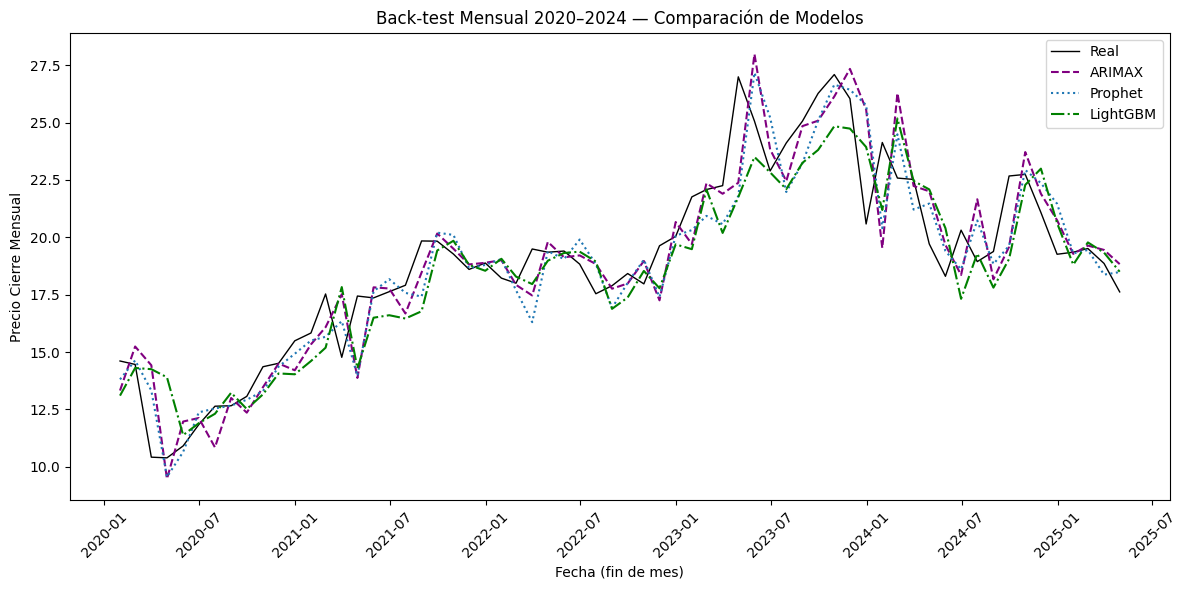

In [ ]:
common_idx = reals_m.index
plt.figure(figsize=(12,6))
plt.plot(common_idx, reals_m,          label='Real',      color='black', linewidth=1)
plt.plot(preds_m.index,   preds_m,      '--', color='purple', label='ARIMAX')
plt.plot(preds_p.index,   preds_p,    ':',  color='tab:blue', label='Prophet')
plt.plot(preds_lgb_m.index, preds_lgb_m,'-.', color='green', label='LightGBM')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.title('Back-test Mensual 2020–2024 — Comparación de Modelos')
plt.xlabel('Fecha (fin de mes)')
plt.ylabel('Precio Cierre Mensual')
plt.legend()
plt.tight_layout()
plt.show()

En el back-testing mensual de 2020–2024, Prophet se anota el mejor RMSE (1.698) y un MAE de 1.229, reflejando la menor dispersión cuadrática y un error medio cercano al 6 % sobre un precio de referencia de ~20 ¢/lb. Su curva azul punteada sigue con fidelidad las oscilaciones de la serie real, aunque tiende a suavizar ligeramente los valles profundos y a sobrerreaccionar en los picos.

ARIMAX (línea violeta a rayas) logra un MAE de 1.303 y un RMSE de 1.785. Se comporta de forma notablemente estable, con menos ruido en las transiciones entre meses y una buena captura de la tendencia general, pero queda un peldaño por debajo de Prophet en precisión cuadrática y un poco mejor que LightGBM en error absoluto.

LightGBM cuenta con un MAE de 1.415 y el RMSE más alto (1.827), lo que indica algo más de dispersión en la parte cuadrática. No obstante, su trazo verde punteado refleja muy bien los grandes movimientos.

### **Eleccion final**

Después de evaluar a fondo los tres enfoques y sopesar no solo las métricas de back-test sino también los requisitos de despliegue y mantenimiento, mi apuesta principal es LightGBM.

Aunque Prophet obtuvo el RMSE más bajo (1.698 vs. 1.827 de LightGBM) y un MAE competitivo, su efecto prominente en picos y valles obliga a ajustes adicionales de estacionalidad y complica un poco el pipeline.

Prophet pasará a ser nuestro modelo de respaldo y monitor de tendencia (tras pulir su estacionalidad diaria), útil si alguna exógena deja de llegar o se complica la integración de Stan. ARIMAX, por su parte, seguirá vigente como alternativa ligera y estable cuando queramos algo sin librerías externas.

Pero para las predicciones oficiales de cierre mensual, elige LightGBM: combina precisión, velocidad y simplicidad de despliegue en un único paquete.